# Injury Dataset - ANALYSES

## context
The datasets are published accompanying the Study "Injury Prediction in Competitive Runners with Machine Learning"

by Lövdal, Sofie; den Hartigh, Ruud; Azzopardi, George 

Published in: International journal of sports physiology and performance.

link : https://pure.rug.nl/ws/portalfiles/portal/183763727/_15550273_International_Journal_of_Sports_Physiology_and_Performance_Injury_Prediction_in_Competitive_Runners_With_Machine_Learning.pdf

The paper describes how the XGBoost machine learning model is used to predict injuries. Out of the Top 5 features with the highest importance the most were related to the manually entered by the athletes, subjective metrics. And although the evaluation of the athletes are important, I know from myself that tracking everyday is hard. During the process we therefore focus on factal metrics.

## aim
For our analyses we have two goals.
1. encounter the data as new with all the basic approaches and build Hypothesis
2. testing Hypothesis 

## process
### 1. general Analyses

For general analytics like Regression, distribution, outliers, getting a feeling for the data - the sheer amount of columns impede most of the visual approaches. That's why we check in the following manner

- a) for distribution
    
    - Kernel Density Estimate with randomized subplot for visual impressions
    
    - Anderson-Darling-Test for normal, exponential, Gumble or logistic distribution (result: no distribution detected)
    
    - Shapiro-Wilk-Test for lognormal distribution. (result: injury follows a lognormal distribution)

- b) for outliers 

    - Isolation Forest Model

    - IQR & Z-Score

- c) for regression & correlation 

    - Pairplot with prepared subset (df_inj_prep prepared in SQL)

    - lineregress, giving the regression and the Pearson coefficient r as textual outcome


After comparing correlation and regression with or without outliers, I drop outliers following the Isolation Forest model.


### 2.1 Hypothesis 3a: "There is a significant difference in training before an injury."
This is an A/B Test by grouping the datasets in two groups and testing for significant differences between these groups based on every single column.

 - Two groups:
    - normal period: injury = 0
    - pre injury period: injury =1

 - Testing significance with:
    - Mann-Whitney-U-Test (non-parametric) due to no normal distribution

Testing on the four focused metrics mileage (TotalKm), high intesity (z5), number of training sessions (Sessions) and number of restdays (RestDay) all showed significant differences with minor restriction on some parts of regarded periods (f.e. significance for one week and two weeks before injury but not on three weeks before injury)


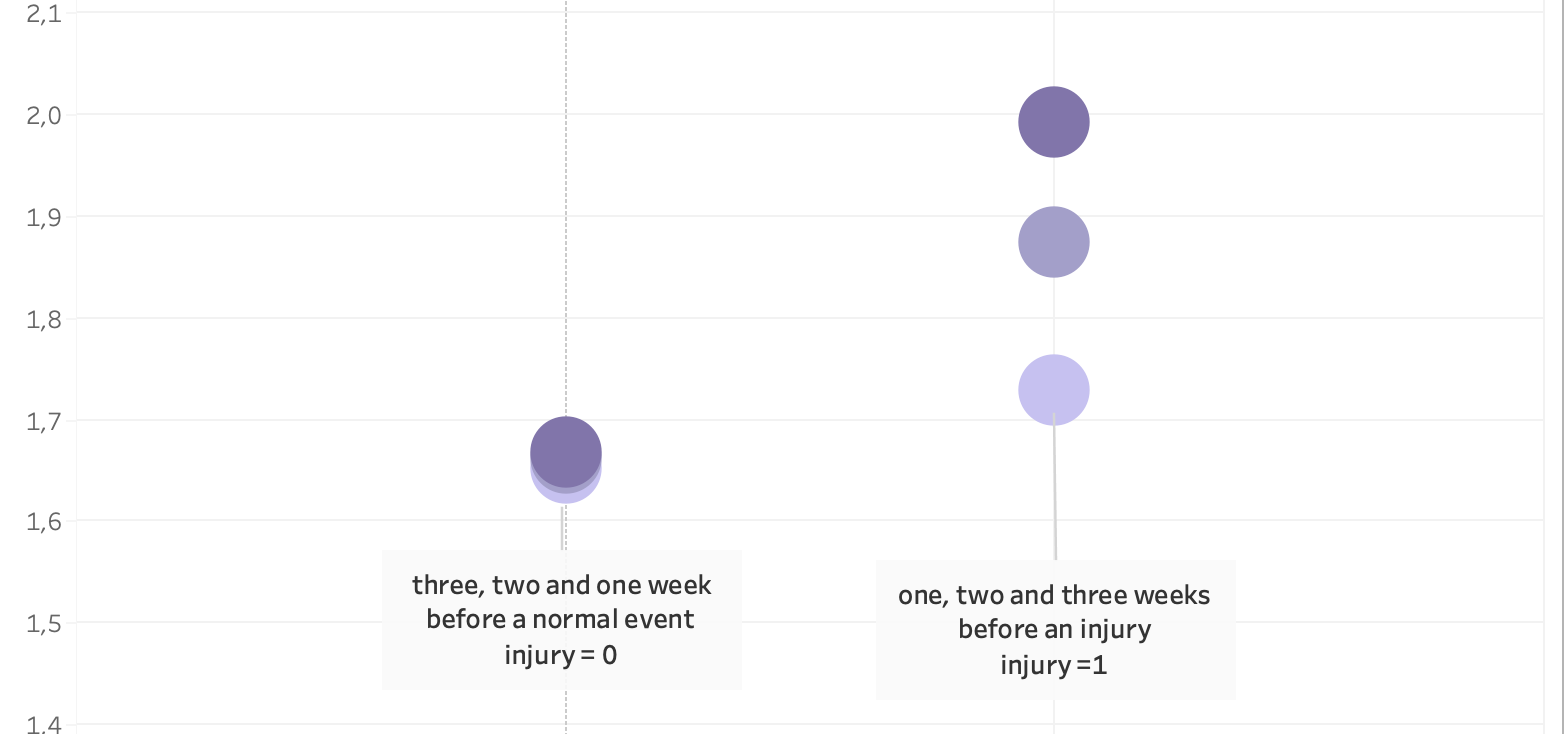


### 2.2 Hypothesis 3b: "Inconsistent Training increases injury risk and can then be used for prediction."
After finding significant differences in training before an injury the assumption is that these differences show inconsistency and effect injury. 

For proving that we test for correlation by using
- Spearman Test
- Heatmap

There are no correlation.

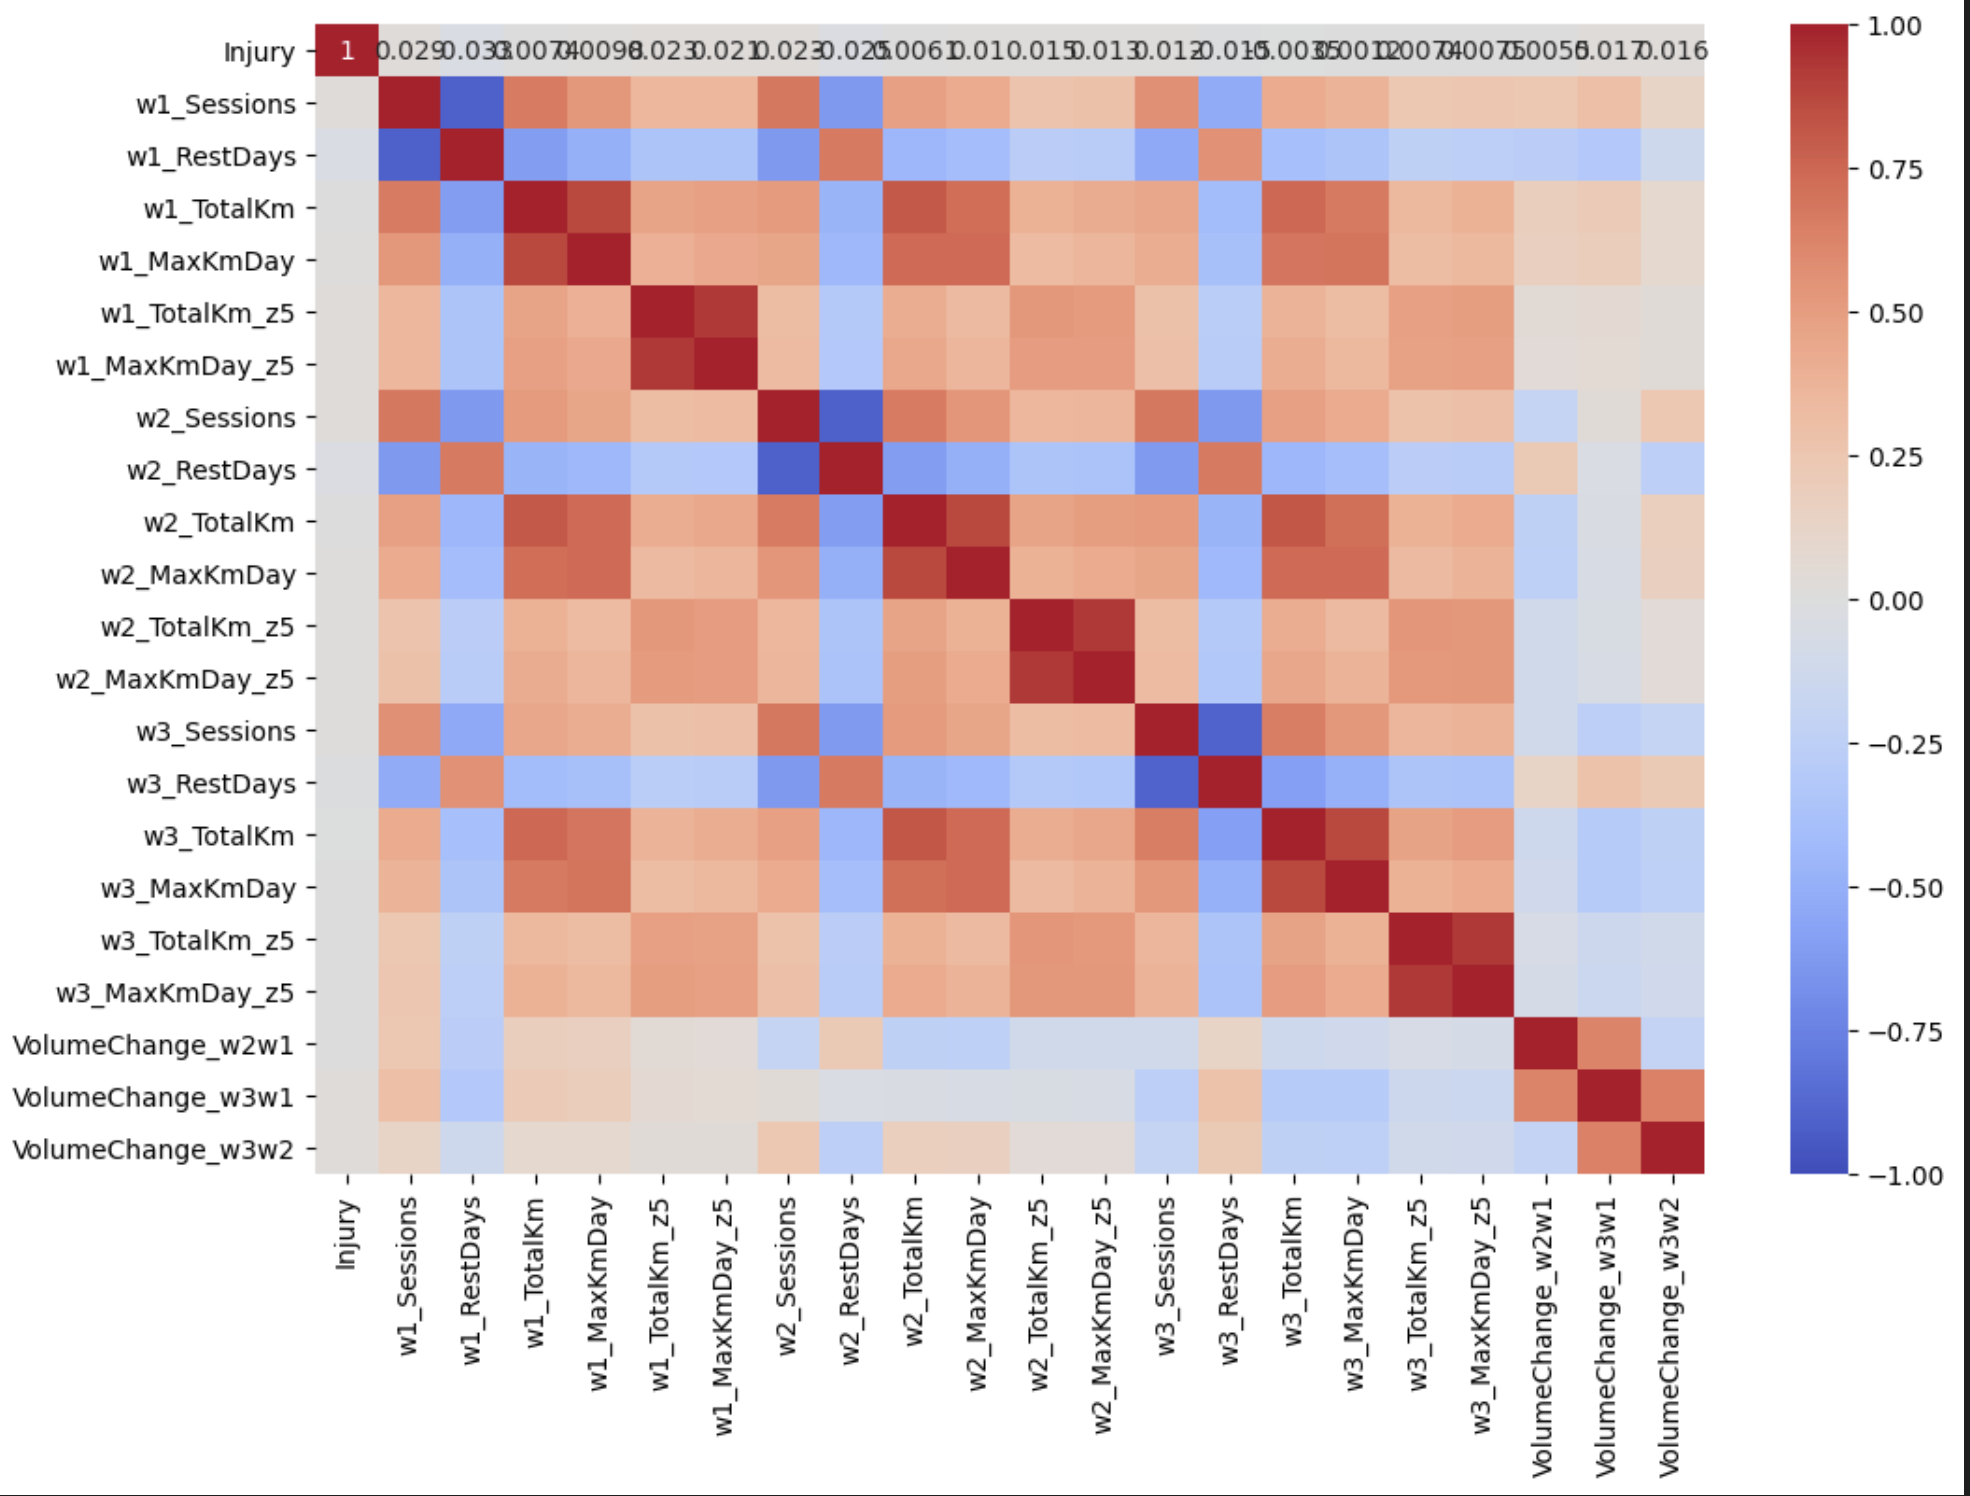

## result
So we could verify the Hypothesis 3a but have to reject the Hypothesis 3b.

## further steps
as the paper suggests that there must be something, by using Machine Learning in the TRAIN-notebook, we try to get closer to that.

-------------------------

In [45]:
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

import io
import itertools

from scipy.stats import anderson
from scipy.stats import shapiro
from scipy.stats import zscore
from scipy.stats import mannwhitneyu
from scipy.stats import linregress

import warnings
warnings.filterwarnings("ignore")


# _. load data

### SQAlchemy

In [2]:
from sqlalchemy import create_engine, types
from sqlalchemy import text # to be able to pass string
from sqlalchemy.exc import SQLAlchemyError
from dotenv import dotenv_values # to load the data from .env file

preparing the connection

In [3]:
#load the data from .env file
config = dotenv_values()

# define variables for the login
pg_user = config['AZURE_USER'] 
pg_host = config['AZURE_HOST']
pg_port = config['AZURE_PORT']
pg_db = config['AZURE_DB']
pg_schema = config['AZURE_SCHEMA']
pg_pass = config['AZURE_PASS']

# build the URL
url = f'postgresql://{pg_user}:{pg_pass}@{pg_host}:{pg_port}/{pg_db}'

# create the engine
engine = create_engine(url, echo=False)
engine.url

# build the search path
my_schema = pg_schema 
with engine.begin() as conn: 
    result = conn.execute(text(f'SET search_path TO {my_schema};'))

testing the connection

In [4]:
def test_db_connection(engine):
    try:
        connection = engine.connect() # including 'connection' as variable to close the connection
        print("Connection successful!")
        connection.close() # closing the connection
        return True
    except SQLAlchemyError as e:
        print(f"Connection failed: {e}")
        return False

# Test the connection
test_db_connection(engine)

Connection successful!


True

reading DataFrames FROM Database

In [5]:
# weeks

df_inj_weeks = pd.read_sql(sql=text('SELECT * FROM public.df_inj_weeks_clean;'), con=engine)

df_inj_weeks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42798 entries, 0 to 42797
Data columns (total 75 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   w1_Sessions                  42798 non-null  float64
 1   w1_RestDays                  42798 non-null  float64
 2   w1_TotalKm                   42798 non-null  float64
 3   w1_MaxKmDay                  42798 non-null  float64
 4   w1_TotalKm_z3z4z5            42798 non-null  float64
 5   w1_ToughSessions_z5          42798 non-null  float64
 6   w1_DaysIntervalSessions      42798 non-null  float64
 7   w1_TotalKm_z3z4              42798 non-null  float64
 8   w1_MaxKmDay_z3z4             42798 non-null  float64
 9   w1_TotalKm_z5                42798 non-null  float64
 10  w1_MaxKmDay_z5               42798 non-null  float64
 11  w1_HoursAlternativeTraining  42798 non-null  float64
 12  w1_StrengthTrainings         42798 non-null  float64
 13  w1_AvgExertion  

In [25]:
# days

df_inj_days = pd.read_sql(sql=text('SELECT * FROM public.df_inj_days_clean;'), con=engine)

df_inj_days.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42766 entries, 0 to 42765
Data columns (total 80 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   d7_Sessions                  42766 non-null  float64
 1   d7_RestDay                   42766 non-null  int64  
 2   d7_TotalKm                   42766 non-null  float64
 3   d7_KmZ3z4                    42766 non-null  float64
 4   d7_KmZ5                      42766 non-null  float64
 5   d7_KmSprint                  42766 non-null  float64
 6   d7_StrengthTraining          42766 non-null  float64
 7   d7_HoursAlternativeTraining  42766 non-null  float64
 8   d7_PreRest                   42766 non-null  float64
 9   d7_Exertion                  42766 non-null  float64
 10  d7_TrainingSuccess           42766 non-null  float64
 11  d6_Sessions                  42766 non-null  float64
 12  d6_RestDay                   42766 non-null  int64  
 13  d6_TotalKm      

In [7]:
# combined subset

df_inj_prep = pd.read_sql(sql=text('SELECT * FROM public.df_inj_prep;'), con=engine)

df_inj_prep.head()

,DayNumber,AthletesID,Injury,w1_Sessions,w1_RestDays,w1_TotalKm,w1_MaxKmDay,w1_TotalKm_z5,w2_Sessions,w2_RestDays,...,d3_TotalKm,d3_KmZ5,d2_Sessions,d2_RestDay,d2_TotalKm,d2_KmZ5,d1_Sessions,d1_RestDay,d1_TotalKm,d1_KmZ5
0,0,5,0,3.0,4.0,100.0,90.0,0.0,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,880,19,0,9.0,0.0,172.0,60.0,18.0,8.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,881,19,0,8.0,0.0,171.5,60.0,20.5,9.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,882,19,0,7.0,1.0,143.5,60.0,20.5,9.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,883,19,0,6.0,1.0,144.5,60.0,20.5,9.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#  1. Analyses

1. distribution / regression

Using visual plots can only work for the subset (42 columns)

2. outliers

3. significance of change hue injury=0 and injury=1 for :
- TotalKm in total average and on each athlete (week)
- VolumeChange in total and on each athlete (week)
- RestDays (week)
- TotalKm_z5 (week)
- TotalKm (days)
- 

## 1.1 distribution - WEEK

As I have so many columns it will not be possible to check all metrics visually. Still I would like to have some visual impression that's why I build a randomised subset to do some KDE plots

In [ ]:
## building a randomised subset

# include DaNumber and Injury
must_include = ['DayNumber', 'Injury']

# exclude AthletesID
all_columns = [col for col in df_inj_weeks.columns if col != 'AthletesID']

# randomized selection 15 columns
random_columns = must_include + pd.Series(all_columns).sample(n=15, random_state=42).tolist()

# randomized selection 150 rows
random_rows = df_inj_weeks.sample(n=150, random_state=42)

# combine to a dataframe
random_data = random_rows[random_columns]


### 1.1.1 Kernel Density Estimate (KDE)

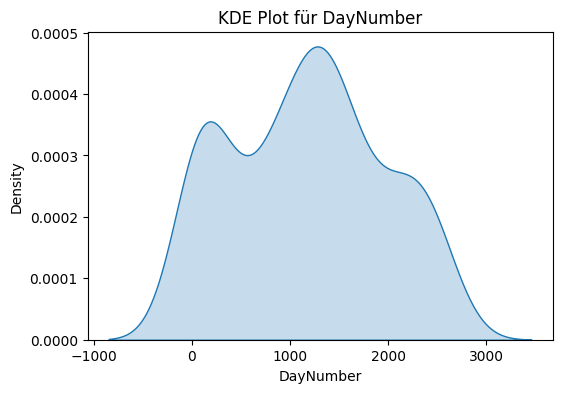

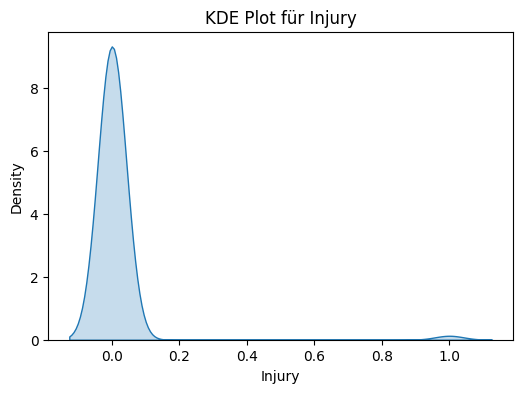

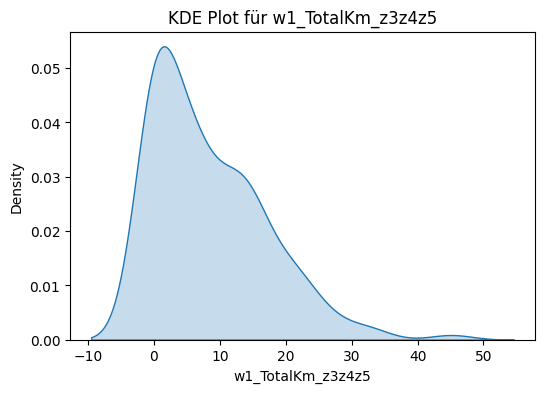

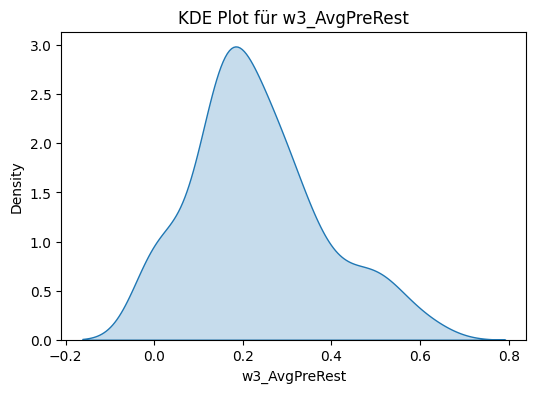

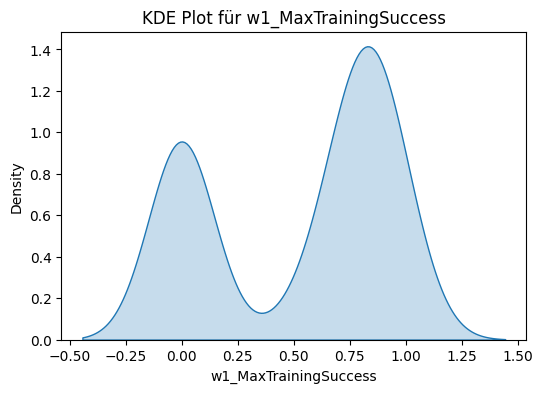

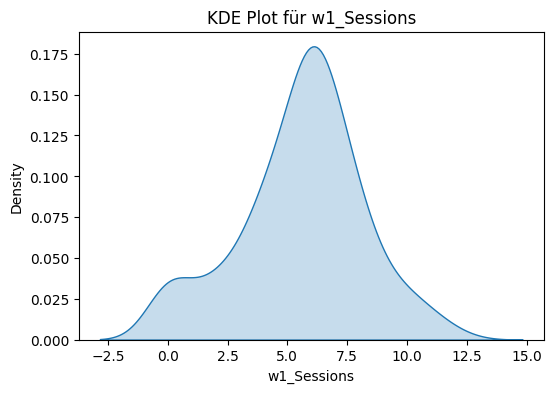

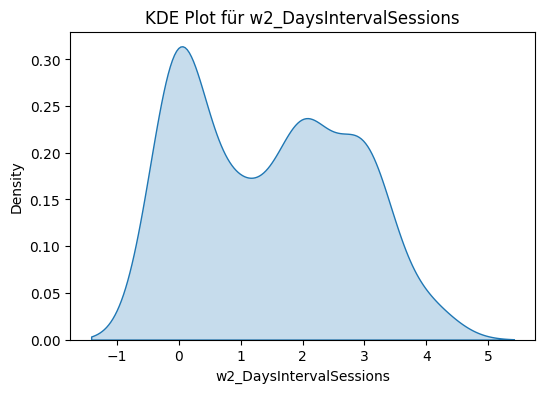

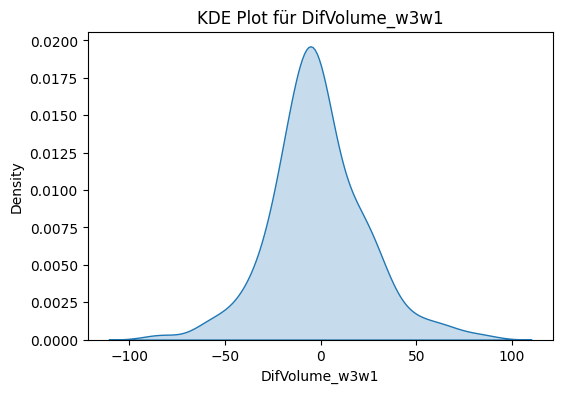

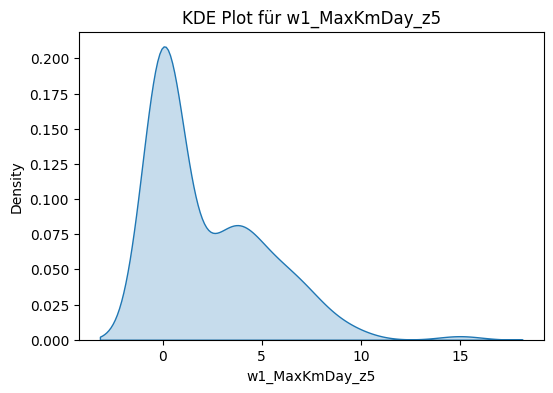

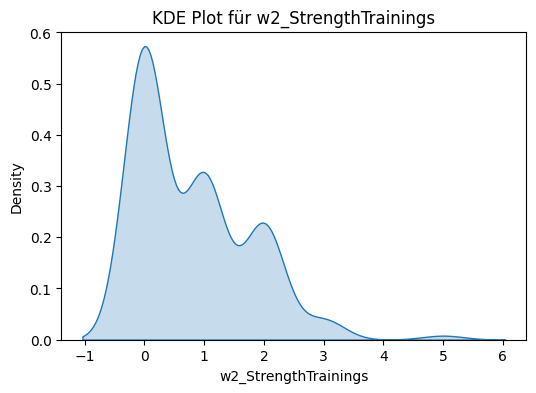

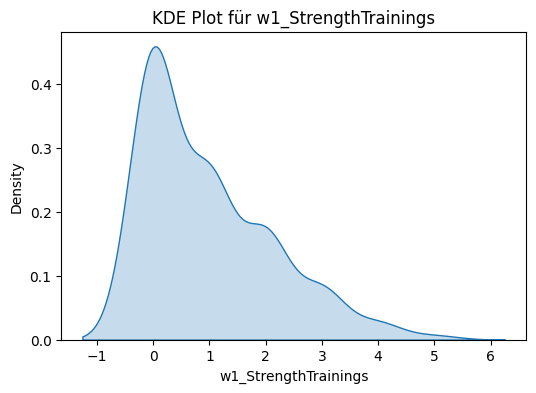

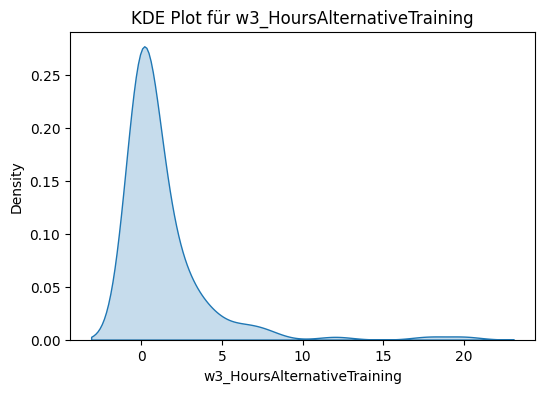

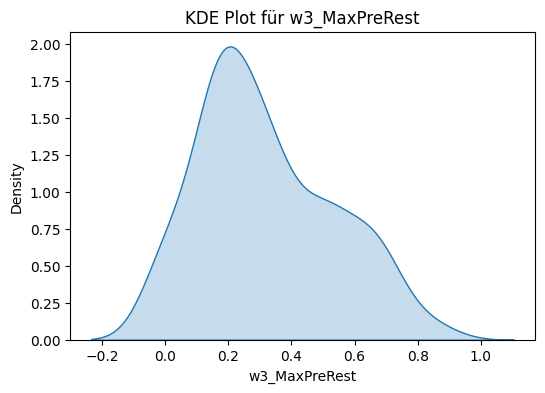

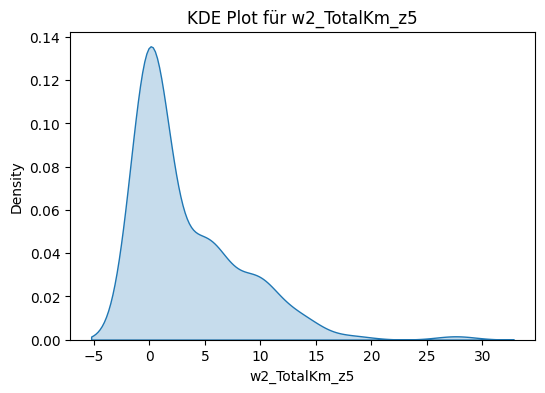

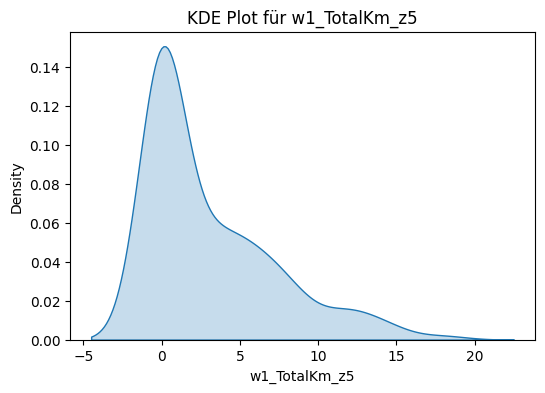

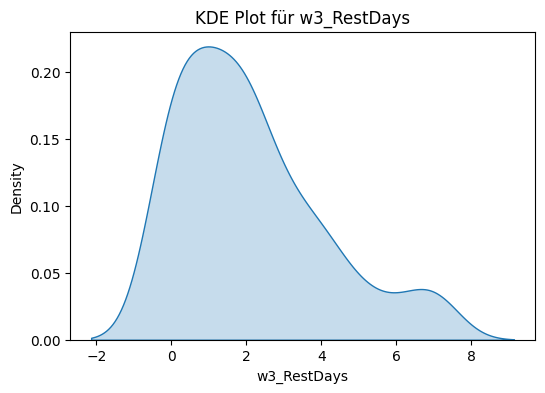

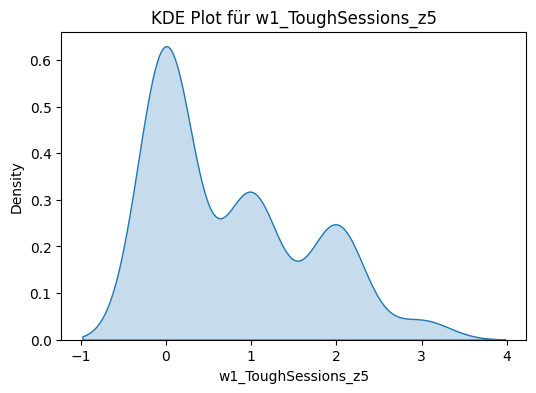

In [35]:
for col in random_data.columns:
    plt.figure(figsize=(6, 4))
    sns.kdeplot(random_data[col], shade=True)
    plt.title(f"KDE Plot für {col}")
    plt.show()

### 1.1.2 Anderson-Darling-Test for distribution

So we can see very different distributions - skewnesses to left and right or multiple archs. I will use a looping over the Anderson-Darling-Test to see if there is any distribution. 

I test for:
- normal distribution (Gauß - symmetric to the mean)
- exponential distribution (constante rate, onesided, positive)
- Gumbel distribution = extreme value type 1 (for maximum and minimum values)
- logistic distribution (similar to normal but with heavier sides)

In [39]:
# List of distributions to test
distributions = ['norm', 'expon', 'gumbel', 'logistic']

# Function to apply Anderson-Darling test and print results
def check_distribution(df):
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:  # Only numeric columns
            print(f"Checking distribution for: {col}")
            for dist in distributions:
                result = anderson(df[col], dist=dist)
                print(f" - {dist}: Statistic = {result.statistic:.4f}, Critical Value (5%) = {result.critical_values[2]:.4f}")
                
                # Compare the test statistic with the critical value at the 5% significance level
                if result.statistic > result.critical_values[2]:
                    print(f"   ❌ The data **does NOT fit** the {dist} distribution.")
                else:
                    print(f"   ✅ The data **fits** the {dist} distribution.")
            print("-" * 50)

# Example call for your dataset
check_distribution(df_inj_weeks)


Checking distribution for: w1_Sessions
 - norm: Statistic = 629.5613, Critical Value (5%) = 0.7870
   ❌ The data **does NOT fit** the norm distribution.
 - expon: Statistic = inf, Critical Value (5%) = 1.3410
   ❌ The data **does NOT fit** the expon distribution.
 - gumbel: Statistic = 830.1653, Critical Value (5%) = 0.7560
   ❌ The data **does NOT fit** the gumbel distribution.
 - logistic: Statistic = 487.6332, Critical Value (5%) = 0.6600
   ❌ The data **does NOT fit** the logistic distribution.
--------------------------------------------------
Checking distribution for: w1_RestDays
 - norm: Statistic = 2305.0708, Critical Value (5%) = 0.7870
   ❌ The data **does NOT fit** the norm distribution.
 - expon: Statistic = inf, Critical Value (5%) = 1.3410
   ❌ The data **does NOT fit** the expon distribution.
 - gumbel: Statistic = 3707.7761, Critical Value (5%) = 0.7560
   ❌ The data **does NOT fit** the gumbel distribution.
 - logistic: Statistic = 1790.5559, Critical Value (5%) = 0.6

There are no distributions so far. I will also test for lognormal distribution

### 1.1.3 Shapiro-Wilk-Test for lognormal distribution

In [43]:
# Function to test lognormality with Shapiro-Wilk Test
def test_lognormality(column_data, column_name):
    
    # Remove non-positive values (log is undefined for 0 and negatives)
    column_data = column_data[column_data > 0]  
    
    if len(column_data) < 3:  # Need at least 3 values for statistical tests
        print(f"⚠️ Not enough positive values to test lognormality for {column_name}")
        return

    # Log-transform the data
    log_data = np.log(column_data)

    # Shapiro-Wilk test for normality on log-transformed data
    stat, p_value = stats.shapiro(log_data)

    # Interpretation
    if p_value > 0.05:
        print(f"✅ {column_name} follows a lognormal distribution (p={p_value:.4f})")
    else:
        print(f"❌ {column_name} does NOT follow a lognormal distribution (p={p_value:.4f})")

# use on df_inj_weeks
for col in df_inj_weeks.columns:
    test_lognormality(df_inj_weeks[col], col)


❌ w1_Sessions does NOT follow a lognormal distribution (p=0.0000)
❌ w1_RestDays does NOT follow a lognormal distribution (p=0.0000)
❌ w1_TotalKm does NOT follow a lognormal distribution (p=0.0000)
❌ w1_MaxKmDay does NOT follow a lognormal distribution (p=0.0000)
❌ w1_TotalKm_z3z4z5 does NOT follow a lognormal distribution (p=0.0000)
❌ w1_ToughSessions_z5 does NOT follow a lognormal distribution (p=0.0000)
❌ w1_DaysIntervalSessions does NOT follow a lognormal distribution (p=0.0000)
❌ w1_TotalKm_z3z4 does NOT follow a lognormal distribution (p=0.0000)
❌ w1_MaxKmDay_z3z4 does NOT follow a lognormal distribution (p=0.0000)
❌ w1_TotalKm_z5 does NOT follow a lognormal distribution (p=0.0000)
❌ w1_MaxKmDay_z5 does NOT follow a lognormal distribution (p=0.0000)
❌ w1_HoursAlternativeTraining does NOT follow a lognormal distribution (p=0.0000)
❌ w1_StrengthTrainings does NOT follow a lognormal distribution (p=0.0000)
❌ w1_AvgExertion does NOT follow a lognormal distribution (p=0.0000)
❌ w1_MinE

Injury follows a lognormal distribution!

## 1.2 outliers - WEEK

As we could see for the distribution, a visual approach doesn't make much sense. And also the amount of columns invites to think of a more complexe method then f.e. IQR-methode. As we want to use Machine Learning for a Prediction Model later on, we use a model here to detect the outliers:

### 1.2.1 IsolationForest 

The IsolationForest is an algorithm for detecting outliers (anomalies). It is based on decision trees and works on the principle that outliers are easier to isolate than regular data points.
It is useful for bigger or more complex datasets. I constat this as a complex dataset because I want to see patterns of combined attributes.


Random Partitioning: The algorithm creates many random decision trees by randomly dividing the data into subsets.

Depth of isolation: Points that can be isolated early in the tree (i.e. after a few splits) are considered as outliers because they are rare in the data.

Anomaly Score: The average depth at which a point is isolated determines its anomaly score. Usually between 1 and -1. A low score means the point is a likely outlier.

In [44]:
from sklearn.ensemble import IsolationForest

# excluding column DayNumber and AthletesID
ignored_columns = ['AthletesID', 'DayNumber']  
df_attributes = df_inj_weeks.drop(columns=ignored_columns, errors='ignore') 

iso = IsolationForest(contamination='auto', random_state=42)  # automatic decision for 
df_inj_weeks['outlier'] = iso.fit_predict(df_attributes)

# identify the outliers
outliers = df_inj_weeks[df_inj_weeks['outlier'] == -1]

# calculate used contamination
contamination_used = (df_inj_weeks['outlier'] == -1).mean()

# calculate number of affected rows
affected_columns = (outliers.isnull().sum() + (outliers.nunique() > 1)).sum()

print(f"The model recocnized {contamination_used:.2%} of the dates as outlier.")
print(f"Number of recognozed outliers: {outliers.shape[0]} of the total of {df_inj_weeks.shape[0]} rows.")
print(f"Number of affected columns: {affected_columns} out of {df_inj_weeks.shape[1]} in total.")


The model recocnized 6.27% of the dates as outlier.
Number of recognozed outliers: 2684 of the total of 42798 rows.
Number of affected columns: 75 out of 76 in total.


About 6% are declared as outliers, but couldn't they be a pattern itself?
Let's have a closer look.

In [ ]:
outliers.describe()

,w1_Sessions,w1_RestDays,w1_TotalKm,w1_MaxKmDay,w1_TotalKm_z3z4z5,w1_ToughSessions_z5,w1_DaysIntervalSessions,w1_TotalKm_z3z4,w1_MaxKmDay_z3z4,w1_TotalKm_z5,...,AthletesID,Injury,VolumeChange_w2w1,VolumeChange_w3w1,VolumeChange_w3w2,DayNumber,DifVolume_w2w1,DifVolume_w3w2,DifVolume_w3w1,outlier
count,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,...,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.000000,2684.0
mean,6.146796,2.168033,70.644560,19.632489,14.955887,0.847988,1.796200,8.861289,5.890574,5.858458,...,35.779061,0.025335,-0.168301,-0.365991,-0.197638,1298.575633,4.026341,1.603204,5.629545,-1.0
std,3.703116,2.560285,56.178691,15.640247,14.361883,1.065499,1.460822,11.753808,7.566258,9.124287,...,19.625396,0.157171,1.640768,1.980571,1.536790,722.263118,41.542767,41.378939,48.973918,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,-5.030000,-5.030000,-5.030000,0.000000,-211.000000,-211.000000,-217.600000,-1.0
25%,3.000000,0.000000,17.500000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,20.000000,0.000000,-0.460000,-0.790000,-0.460000,794.000000,-19.800000,-19.825000,-22.725000,-1.0
50%,7.000000,1.000000,68.400000,18.800000,13.000000,0.000000,2.000000,3.500000,3.000000,0.000000,...,38.000000,0.000000,0.000000,-0.070000,-0.010000,1228.500000,0.000000,0.700000,6.000000,-1.0
75%,9.000000,4.000000,110.625000,29.000000,24.400000,2.000000,3.000000,15.300000,10.000000,9.000000,...,50.000000,0.000000,0.270000,0.300000,0.280000,1875.000000,28.225000,24.425000,36.925000,-1.0
max,14.000000,7.000000,235.000000,131.000000,100.000000,5.000000,7.000000,74.000000,42.200000,80.000000,...,71.000000,1.000000,5.350000,5.390000,5.350000,2651.000000,191.000000,191.000000,201.000000,-1.0


Which columns are affected the most?

In [ ]:
# compairing the outlier's means with the regular means / excluding the DayNumber

df_means = df_inj_weeks.drop(columns=['DayNumber']).mean()
outlier_means = outliers.drop(columns=['DayNumber']).mean()

diff = (outlier_means - df_means).abs().sort_values(ascending=False)
print("Rows with the biggest differences between Outlier's mean and the normal data's mean :")
print(diff.head(10))  # top 10


Rows with the biggest differences between Outlier's mean and the normal data's mean :
w3_TotalKm           27.466972
w2_TotalKm           25.415850
w1_TotalKm           21.100649
w3_MaxKmDay           7.157809
w2_TotalKm_z3z4z5     7.052872
w2_MaxKmDay           7.023943
w3_TotalKm_z3z4z5     6.677868
DifVolume_w3w1        6.366323
w1_MaxKmDay           5.623234
w1_TotalKm_z3z4z5     5.522266
dtype: float64


The differences are mainly in the distances - as the team has different type of athletes, maybe its just the Ultra-Runner. Let's have a look for the AthletesID

In [ ]:
print(f"{outliers['AthletesID'].nunique()} athletes have outliers in their data!")

57 athletes have outliers in their data!


So that does not explain it. Maybe there was a special Ultra-Run, so everybody in a certain period may have trained longer distances?

In [ ]:
print(f"The outliers are distributed on {outliers['DayNumber'].nunique()} different days!")

The outliers are distributed on 1634 different days!


Maybe a more visual approach can clarify.

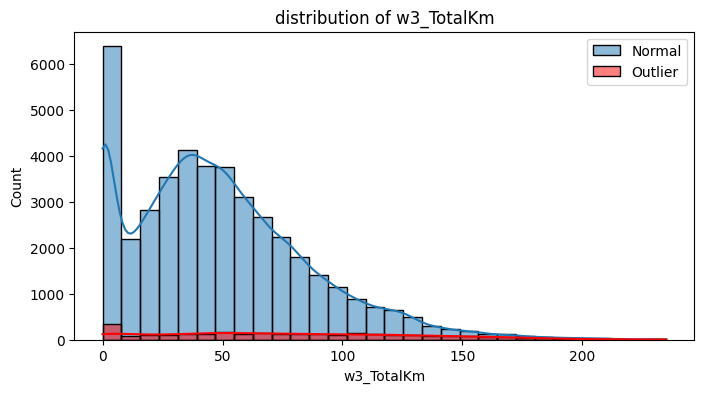

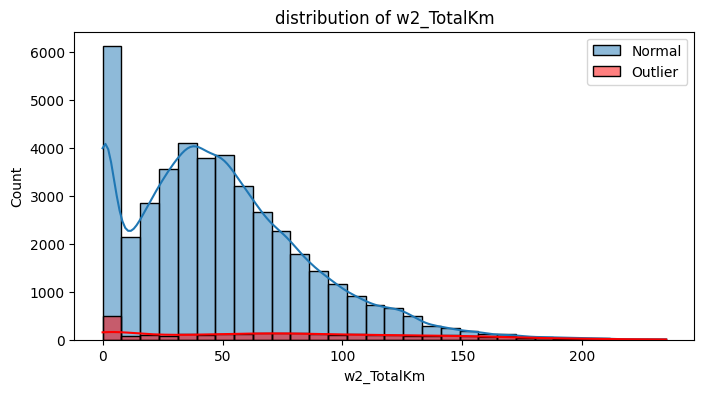

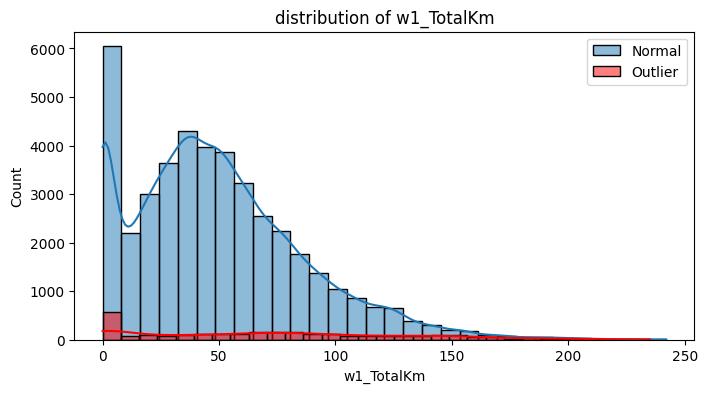

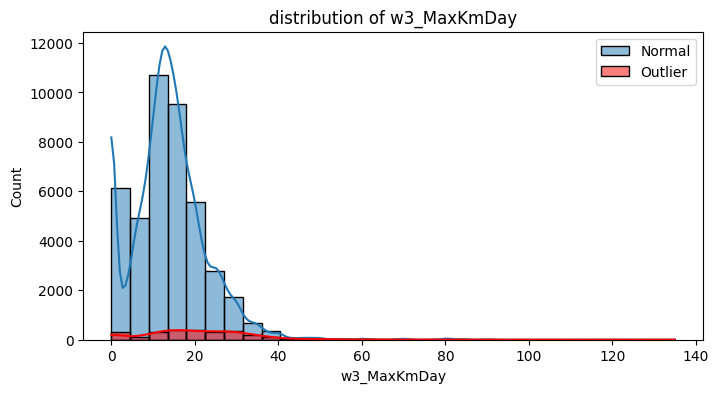

In [ ]:
# plotting the outlier's distribution compared to the normal data

cols_to_check = ['w3_TotalKm', 'w2_TotalKm', 'w1_TotalKm', 'w3_MaxKmDay']
for col in cols_to_check:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_inj_weeks[col], kde=True, bins=30, label='Normal')
    sns.histplot(outliers[col], kde=True, bins=30, color='red', label='Outlier')
    plt.legend()
    plt.title(f'distribution of {col}')
    plt.show()

So the outliers are more likely to follow the normal data. Maybe Isolation Forest was not a good choice.

I'll check with IQR and Z-Score.

#### 1.2.2 IQR & Z-Score

In [55]:

# List of columns to check for outliers
cols_to_check = df_inj_weeks.select_dtypes(include=['float64', 'int64']).columns

# Z-Score Method
outliers_zscore = {}
for col in cols_to_check:
    z_scores = stats.zscore(df_inj_weeks[col].dropna())  # Exclude NaN values
    outliers_zscore[col] = np.where(np.abs(z_scores) > 3)[0]  # Z-Score > 3 is considered an outlier

# IQR Method
outliers_iqr = {}
for col in cols_to_check:
    Q1 = df_inj_weeks[col].quantile(0.25)
    Q3 = df_inj_weeks[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers_iqr[col] = df_inj_weeks[(df_inj_weeks[col] < (Q1 - 1.5 * IQR)) | (df_inj_weeks[col] > (Q3 + 1.5 * IQR))].index

# Create a list to store outliers count for each column
outlier_counts = []
total_outliers = set()  # Use a set to count unique outliers even if the row has several
total_rows = len(df_inj_weeks)  # Total number of rows in the dataframe

# Store the number of outliers for each column based on both methods
for col in cols_to_check:
    z_outliers = outliers_zscore[col]
    iqr_outliers = outliers_iqr[col]
    
    unique_outliers = set(z_outliers).union(iqr_outliers)  # Combine both sets to get unique outliers
    if len(unique_outliers) > 0:  # Only include columns with unique outliers > 0
        outlier_counts.append((col, len(z_outliers), len(iqr_outliers), len(unique_outliers)))
        total_outliers.update(unique_outliers)  # Add unique outliers to the total set

# Sort the list by the total unique outliers count in descending order
outlier_counts_sorted = sorted(outlier_counts, key=lambda x: x[3], reverse=True)

# Calculate the percentage of unique outliers
outlier_percentage = (len(total_outliers) / total_rows) * 100

# Print the total percentage of unique outliers in the entire DataFrame
print(f"Total percentage of unique outliers in the DataFrame: {outlier_percentage:.2f}%")

# Print the sorted output
for col, z_count, iqr_count, unique_count in outlier_counts_sorted:
    print(f"Column: {col}")
    print(f"Z-Score Method - Outliers: {z_count}")
    print(f"IQR Method - Outliers: {iqr_count}")
    print(f"Total unique outliers detected: {unique_count}")
    print()

Total percentage of unique outliers in the DataFrame: 66.40%
Column: VolumeChange_w3w1
Z-Score Method - Outliers: 1518
IQR Method - Outliers: 5208
Total unique outliers detected: 5208

Column: VolumeChange_w3w2
Z-Score Method - Outliers: 1304
IQR Method - Outliers: 4550
Total unique outliers detected: 4550

Column: VolumeChange_w2w1
Z-Score Method - Outliers: 1271
IQR Method - Outliers: 4527
Total unique outliers detected: 4527

Column: w2_HoursAlternativeTraining
Z-Score Method - Outliers: 787
IQR Method - Outliers: 4493
Total unique outliers detected: 4493

Column: w3_HoursAlternativeTraining
Z-Score Method - Outliers: 729
IQR Method - Outliers: 4402
Total unique outliers detected: 4402

Column: w1_HoursAlternativeTraining
Z-Score Method - Outliers: 791
IQR Method - Outliers: 4381
Total unique outliers detected: 4381

Column: w3_Sessions
Z-Score Method - Outliers: 15
IQR Method - Outliers: 4293
Total unique outliers detected: 4293

Column: w2_Sessions
Z-Score Method - Outliers: 15
IQ

So with the IQR and Z-Score a total of >60% are valuated as Outliers. What makes the Isolation Forest result more reasonable.

I will see if the detected Outliers of the model have any effect on regression and correlation by testing two version of it and then decide if to keep them or drop them.

In [64]:
## building an outlier-free version dataframe following the Isolation Forest model (only 6% outliers)

# excluding column DayNumber and AthletesID
ignored_columns = ['AthletesID', 'DayNumber']  
df_attributes = df_inj_weeks.drop(columns=ignored_columns, errors='ignore')

# Initialize IsolationForest model
iso = IsolationForest(contamination='auto', random_state=42)  # automatic decision for contamination
df_inj_weeks['outlier'] = iso.fit_predict(df_attributes)

# Identify the outliers
outliers = df_inj_weeks[df_inj_weeks['outlier'] == -1]

# Remove the rows identified as outliers
df_no_outlier = df_inj_weeks[df_inj_weeks['outlier'] != -1].drop(columns='outlier').reset_index(drop=True)

df_no_outlier.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39939 entries, 0 to 39938
Data columns (total 75 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   w1_Sessions                  39939 non-null  float64
 1   w1_RestDays                  39939 non-null  float64
 2   w1_TotalKm                   39939 non-null  float64
 3   w1_MaxKmDay                  39939 non-null  float64
 4   w1_TotalKm_z3z4z5            39939 non-null  float64
 5   w1_ToughSessions_z5          39939 non-null  float64
 6   w1_DaysIntervalSessions      39939 non-null  float64
 7   w1_TotalKm_z3z4              39939 non-null  float64
 8   w1_MaxKmDay_z3z4             39939 non-null  float64
 9   w1_TotalKm_z5                39939 non-null  float64
 10  w1_MaxKmDay_z5               39939 non-null  float64
 11  w1_HoursAlternativeTraining  39939 non-null  float64
 12  w1_StrengthTrainings         39939 non-null  float64
 13  w1_AvgExertion  

## 1.3 regression & correlation - WEEK

I wanted to plot pairplots to get an overview what the data looks like.

As this dataset with it's 72 columns is that complex a pairplot over all combination couldn't work. I tried to build reduced subsets with focus on Sessions, Rest Days, mileage and high intensity.

I combined week and day perspective for that to find out that it's still to complexe. Seperating them didn't help a lot either.

That's why I changed the approach to a more textual then visual.

In [9]:
# code snippet for one pairplot for all weeks - just to see the coding, i droped building the subsets 
"""
sns.pairplot(subplot_weeks, kind='reg', diag_kind='kde', hue='Injury', corner=True)
plt.show()
"""

"\nsns.pairplot(subplot_weeks, kind='reg', diag_kind='kde', hue='Injury', corner=True)\nplt.show()\n"

### 1.3.1 linegress with outliers

Here is the textual approach using linregress with the Perason coefficient r - including the outliers

In [20]:
# test all columns (due to all being numerical) 

columns = df_inj_weeks.columns
results = []

# iterate over all column pairs
for col1, col2 in itertools.combinations(columns, 2):
    x, y = df_inj_weeks[col1].dropna(), df_inj_weeks[col2].dropna()

    # only calculate if there are enough entries
    if len(x) > 10 and len(y) > 10:
        slope, intercept, r_value, p_value, std_err = linregress(x, y)

        # Symbols for regression
        if p_value < 0.05:  # significant
            if slope > 0:
                symbol = "🔴"  # positive trend
                trend = f"✅ {symbol} a slight positive regression" if slope < 0.5 else f"✅ {symbol} a strong positive regression"
            else:
                symbol = "🔵"  # negative trend
                trend = f"✅ {symbol} a slight negative regression" if slope > -0.5 else f"✅ {symbol} a strong negative regression"

            # Korrelation ausgeben, wenn sie stark genug ist
            if abs(r_value) > 0.3:
                correlation_text = f" with a correlation (r={r_value:.3f})"
                results.append((abs(r_value), f"Between '{col1}' and '{col2}', there is {trend}{correlation_text} (slope={slope:.3f}, p={p_value:.3f})."))
            else:
                results.append((0, f"Between '{col1}' and '{col2}', there is {trend} (slope={slope:.3f}, p={p_value:.3f})."))
        else:
            results.append((0, f"Between '{col1}' and '{col2}', there is ❌ no significant regression (slope={slope:.3f}, p={p_value:.3f})."))

# Ergebnisse nach der absoluten Korrelation sortieren (höchste zuerst)
results.sort(reverse=True, key=lambda x: x[0])

# Anzahl der maximal angezeigten Ergebnisse
max_results = 50

# Ergebnisse ausgeben
for res in results[:max_results]:
    print(res[1])



Between 'w2_AvgTrainingSuccess' and 'w2_MaxTrainingSuccess', there is ✅ 🔴 a strong positive regression with a correlation (r=0.981) (slope=1.125, p=0.000).
Between 'w1_AvgTrainingSuccess' and 'w1_MaxTrainingSuccess', there is ✅ 🔴 a strong positive regression with a correlation (r=0.981) (slope=1.126, p=0.000).
Between 'w3_AvgTrainingSuccess' and 'w3_MaxTrainingSuccess', there is ✅ 🔴 a strong positive regression with a correlation (r=0.981) (slope=1.126, p=0.000).
Between 'w1_MaxTrainingSuccess' and 'w2_MaxTrainingSuccess', there is ✅ 🔴 a strong positive regression with a correlation (r=0.941) (slope=0.942, p=0.000).
Between 'w2_MaxTrainingSuccess' and 'w3_MaxTrainingSuccess', there is ✅ 🔴 a strong positive regression with a correlation (r=0.941) (slope=0.941, p=0.000).
Between 'w1_AvgTrainingSuccess' and 'w2_AvgTrainingSuccess', there is ✅ 🔴 a strong positive regression with a correlation (r=0.933) (slope=0.934, p=0.000).
Between 'w2_AvgTrainingSuccess' and 'w3_AvgTrainingSuccess', the

### 1.3.2 linegress without outliers

Comparing with the subset without outliers to decide if or if not to drop them.

In [69]:
## compare between with or without outliers

# List of columns in the dataframe - for both the same
columns = df_no_outlier.columns
results_inj_weeks = []
results_no_outlier = []

# Counters for significant correlations
significant_inj_weeks = 0
significant_no_outlier = 0

# Iterate over all column pairs
for col1, col2 in itertools.combinations(columns, 2):
    # Get the data for the pair of columns, excluding NaN values
    x_inj_weeks, y_inj_weeks = df_inj_weeks[col1].dropna(), df_inj_weeks[col2].dropna()
    x_no_outlier, y_no_outlier = df_no_outlier[col1].dropna(), df_no_outlier[col2].dropna()

    # Only calculate if there are enough entries
    if len(x_inj_weeks) > 10 and len(y_inj_weeks) > 10 and len(x_no_outlier) > 10 and len(y_no_outlier) > 10:
        # Perform linear regression for both dataframes
        slope_inj_weeks, _, r_value_inj_weeks, p_value_inj_weeks, _ = linregress(x_inj_weeks, y_inj_weeks)
        slope_no_outlier, _, r_value_no_outlier, p_value_no_outlier, _ = linregress(x_no_outlier, y_no_outlier)

        # Check for significant correlations
        if p_value_inj_weeks < 0.05 and abs(r_value_inj_weeks) > 0.3:
            significant_inj_weeks += 1
        if p_value_no_outlier < 0.05 and abs(r_value_no_outlier) > 0.3:
            significant_no_outlier += 1

        # Evaluate trends
        trend_inj_weeks = "positive" if p_value_inj_weeks < 0.05 and slope_inj_weeks > 0 else "negative"
        trend_no_outlier = "positive" if p_value_no_outlier < 0.05 and slope_no_outlier > 0 else "negative"

        # Store results
        results_inj_weeks.append((slope_inj_weeks, abs(r_value_inj_weeks), trend_inj_weeks))
        results_no_outlier.append((slope_no_outlier, abs(r_value_no_outlier), trend_no_outlier))

# Compare results between df_inj_weeks and df_no_outlier
stronger_corr = 0
weaker_corr = 0
equal_corr = 0
equal_significant = 0

for (slope_inj_weeks, r_value_inj_weeks, trend_inj_weeks), (slope_no_outlier, r_value_no_outlier, trend_no_outlier) in zip(results_inj_weeks, results_no_outlier):
    if trend_inj_weeks == trend_no_outlier:
        equal_significant += 1
    elif abs(r_value_inj_weeks) > abs(r_value_no_outlier):
        stronger_corr += 1
    elif abs(r_value_inj_weeks) < abs(r_value_no_outlier):
        weaker_corr += 1
    else:
        equal_corr += 1

# Output the comparison results
print(f"The dataset without outliers (df_no_outlier) has:")
print(f"- {stronger_corr} stronger correlations than df_inj_weeks.")
print(f"- {weaker_corr} weaker correlations than df_inj_weeks.")
print(f"- {equal_corr} correlations that are equal in strength to df_inj_weeks.")
print(f"- {equal_significant} relationships with the same trend as df_inj_weeks.")
print(f"- {significant_inj_weeks} significant correlations in df_inj_weeks.")
print(f"- {significant_no_outlier} significant correlations in df_no_outlier.")


The dataset without outliers (df_no_outlier) has:
- 40 stronger correlations than df_inj_weeks.
- 35 weaker correlations than df_inj_weeks.
- 0 correlations that are equal in strength to df_inj_weeks.
- 2700 relationships with the same trend as df_inj_weeks.
- 824 significant correlations in df_inj_weeks.
- 849 significant correlations in df_no_outlier.


So dropping the outliers has a positive impact on our dataset. That will now be without outliers.

In [70]:
df_inj_weeks = df_no_outlier

So there are a lot of linear regression with positive trends. As I want to stick more to the metrics tracked by devices, I will filter a fact-based dataframe to select what metrics could be reasonable to focus on.

In [72]:
fact_columns =[
 'w1_Sessions',
 'w1_RestDays',
 'w1_TotalKm',
 'w1_MaxKmDay',
 'w1_TotalKm_z3z4z5',
 'w1_ToughSessions_z5',
 'w1_DaysIntervalSessions',
 'w1_TotalKm_z3z4',
 'w1_MaxKmDay_z3z4',
 'w1_TotalKm_z5',
 'w1_MaxKmDay_z5',
 'w1_HoursAlternativeTraining',
 'w1_StrengthTrainings',
 
 'w2_Sessions',
 'w2_RestDays',
 'w2_TotalKm',
 'w2_MaxKmDay',
 'w2_TotalKm_z3z4z5',
 'w2_ToughSessions_z5',
 'w2_DaysIntervalSessions',
 'w2_TotalKm_z3z4',
 'w2_MaxKmDay_z3z4',
 'w2_TotalKm_z5',
 'w2_MaxKmDay_z5',
 'w2_HoursAlternativeTraining',
 'w2_StrengthTrainings',

 'w3_Sessions',
 'w3_RestDays',
 'w3_TotalKm',
 'w3_MaxKmDay',
 'w3_TotalKm_z3z4z5',
 'w3_ToughSessions_z5',
 'w3_DaysIntervalSessions',
 'w3_TotalKm_z3z4',
 'w3_MaxKmDay_z3z4',
 'w3_TotalKm_z5',
 'w3_MaxKmDay_z5',
 'w3_HoursAlternativeTraining',
 'w3_StrengthTrainings',
 
 'AthletesID',
 'Injury',
 'VolumeChange_w2w1',
 'VolumeChange_w3w1',
 'VolumeChange_w3w2',
 'DayNumber',
 'DifVolume_w2w1',
 'DifVolume_w3w2',
 'DifVolume_w3w1']


In [73]:
df_weeks_facts = df_inj_weeks[fact_columns]

In [74]:
# only test on fact based columns

columns = df_weeks_facts.columns
results = []

# iterate over all column pairs
for col1, col2 in itertools.combinations(columns, 2):
    x, y = df_weeks_facts[col1].dropna(), df_weeks_facts[col2].dropna()

    # only calculate if there are enough entries
    if len(x) > 10 and len(y) > 10:
        slope, intercept, r_value, p_value, std_err = linregress(x, y)

        # Symbols for regression
        if p_value < 0.05:  # significant
            if slope > 0:
                symbol = "🔴"  # positive trend
                trend = f"✅ {symbol} a slight positive regression" if slope < 0.5 else f"✅ {symbol} a strong positive regression"
            else:
                symbol = "🔵"  # negative trend
                trend = f"✅ {symbol} a slight negative regression" if slope > -0.5 else f"✅ {symbol} a strong negative regression"

            # Korrelation ausgeben, wenn sie stark genug ist
            if abs(r_value) > 0.3:
                correlation_text = f" with a correlation (r={r_value:.3f})"
                results.append((abs(r_value), f"Between '{col1}' and '{col2}', there is {trend}{correlation_text} (slope={slope:.3f}, p={p_value:.3f})."))
            else:
                results.append((0, f"Between '{col1}' and '{col2}', there is {trend} (slope={slope:.3f}, p={p_value:.3f})."))
        else:
            results.append((0, f"Between '{col1}' and '{col2}', there is ❌ no significant regression (slope={slope:.3f}, p={p_value:.3f})."))

# Ergebnisse nach der absoluten Korrelation sortieren (höchste zuerst)
results.sort(reverse=True, key=lambda x: x[0])

# Anzahl der maximal angezeigten Ergebnisse
max_results = 50

# Ergebnisse ausgeben
for res in results[:max_results]:
    print(res[1])

Between 'w3_TotalKm_z5' and 'w3_MaxKmDay_z5', there is ✅ 🔴 a strong positive regression with a correlation (r=0.929) (slope=0.568, p=0.000).
Between 'w1_TotalKm_z5' and 'w1_MaxKmDay_z5', there is ✅ 🔴 a strong positive regression with a correlation (r=0.927) (slope=0.571, p=0.000).
Between 'w2_TotalKm_z5' and 'w2_MaxKmDay_z5', there is ✅ 🔴 a strong positive regression with a correlation (r=0.927) (slope=0.568, p=0.000).
Between 'w3_TotalKm_z3z4' and 'w3_MaxKmDay_z3z4', there is ✅ 🔴 a strong positive regression with a correlation (r=0.918) (slope=0.597, p=0.000).
Between 'w2_TotalKm_z3z4' and 'w2_MaxKmDay_z3z4', there is ✅ 🔴 a strong positive regression with a correlation (r=0.917) (slope=0.596, p=0.000).
Between 'w1_TotalKm_z3z4' and 'w1_MaxKmDay_z3z4', there is ✅ 🔴 a strong positive regression with a correlation (r=0.917) (slope=0.606, p=0.000).
Between 'w3_Sessions' and 'w3_RestDays', there is ✅ 🔵 a strong negative regression with a correlation (r=-0.910) (slope=-0.691, p=0.000).
Betw

So the metrics about high intesity (z5), mileage (TotalKm) and number of training (sessions) vs resting (Rest days) will be focused.

# 2.1 A/B testing (Hypothesis 3a)

By dividing the Datasets into two groups 
- eventdays where injury=0 
- eventdays where injury=1 

we can compare normal periods with pre-injury-periods and see, if there are any differences.

In a second step we will test if these differences are significant.

## 2.1.1 boxplots

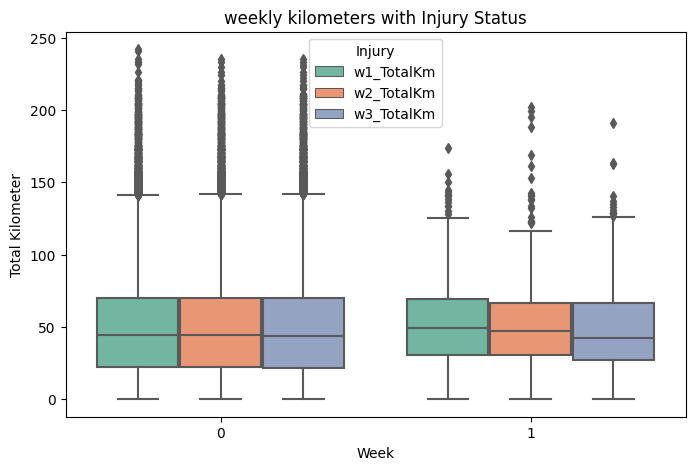

In [19]:
## to plot the changing over time hued by injury I build subplots

# choosing the columns
cols = ["w1_TotalKm", "w2_TotalKm", "w3_TotalKm", "Injury"]

# reducing the dataframe
df_plot = df_inj_weeks[cols]

# DataFrame umstrukturieren (melt)
df_melted = df_plot.melt(id_vars="Injury", var_name="Week", value_name="TotalKm")

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_melted, x="Injury", y="TotalKm", hue="Week", palette="Set2")

# Label
plt.xlabel("Week")
plt.ylabel("Total Kilometer")
plt.title("weekly kilometers with Injury Status")
plt.legend(title="Injury")
plt.show()




As for the group 0 all the average kilometers look very similar over the three weeks before. Differently on pre-injury-periods, where they seem unsteady.

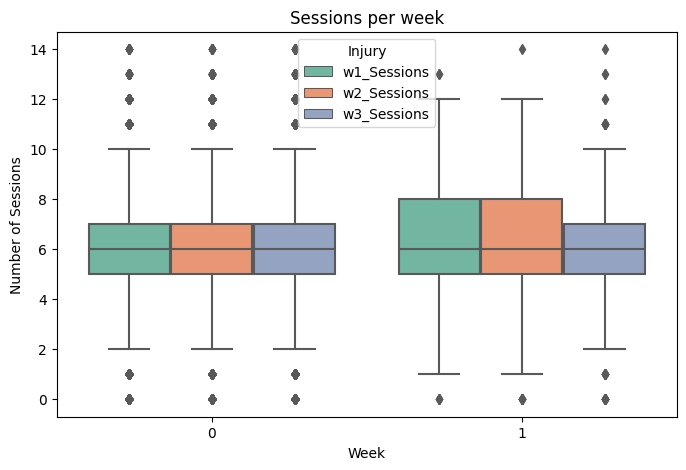

In [20]:
## to plot the changing over time hued by injury I build subplots

# choosing the columns
cols = ["w1_Sessions", "w2_Sessions", "w3_Sessions", "Injury"]

# reducing the dataframe
df_plot = df_inj_weeks[cols]

# DataFrame umstrukturieren (melt)
df_melted = df_plot.melt(id_vars="Injury", var_name="Week", value_name="Sessions")

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_melted, x="Injury", y="Sessions", hue="Week", palette="Set2")

# Label
plt.xlabel("Week")
plt.ylabel("Number of Sessions")
plt.title("Sessions per week")
plt.legend(title="Injury")
plt.show()


For number of sessions these differences are even more visible.

I will now check for the significance of these differences.

## 2.1.2 significance: Mann-Whitney-U-Test

checking for signifcant differences with the Mann Withney U test on

- TotalKm (mileage)
- TotalKm_z5 (high intensity)
- Sessions
- RestDays

### TotalKm - weeks

As the data aren't normal distributed, I choose the Mann-Whitney-U-Test.

This test is based on the rangs not on the means and is testing the Nullhypothesis that both groups (in this case injury=0 vs injury=1) are having the same distribution. By comparing the sum of the rangs of these two groups the U-value tells how strong they are devided. The smaller the value, the bigger the differnces

In [22]:
# preparing by seperate injury-groups for macro perspective

df_w_injury_0 = df_inj_weeks[df_inj_weeks["Injury"] == 0]
df_w_injury_1 = df_inj_weeks[df_inj_weeks["Injury"] == 1]

In [23]:

# testing with mannwhitneyu
print("🔬 Mann-Whitney-U-Test (non-parametric Test):\n")
for week in w_TotalKm:
    stat, p_value = mannwhitneyu(df_w_injury_0[week], df_w_injury_1[week], alternative="two-sided")
    
    # evaluating the significance
    if p_value < 0.05:
        result = f"✅ significant (p={p_value:.5f})"
    else:
        result = f"❌ not significant (p={p_value:.5f})"
    
    print(f"{week}: U={stat:.3f}, {result}")

🔬 Mann-Whitney-U-Test (non-parametric Test):

w1_TotalKm: U=11254266.500, ✅ significant (p=0.00263)
w2_TotalKm: U=11446835.500, ✅ significant (p=0.01858)
w3_TotalKm: U=12070018.500, ❌ not significant (p=0.81424)


As the most significant p-value is from the week before the event, I now check the significance in the Mircroperspective (comparing 7 days)

In [24]:
# preparing by seperate injury-groups for micro perspective

df_injury_0 = df_inj_days[df_inj_days["Injury"] == 0]
df_injury_1 = df_inj_days[df_inj_days["Injury"] == 1]

### TotalKm - days

In [25]:
# preparing the days 

d_TotalKm = ["d7_TotalKm", "d6_TotalKm", "d5_TotalKm", "d4_TotalKm", "d3_TotalKm", "d2_TotalKm", "d1_TotalKm"]

In [27]:
# testing with mannwhitneyu

print("🔬 Mann-Whitney-U-Test (non-parametric Test):\n")
for day in d_TotalKm:
    stat, p_value = mannwhitneyu(df_injury_0[day], df_injury_1[day], alternative="two-sided")
    
    # evaluating the significance
    if p_value < 0.05:
        result = f"✅ significant (p={p_value:.5f})"
    else:
        result = f"❌ not significant (p={p_value:.5f})"
    
    print(f"{day}: U={stat:.3f}, {result}")

🔬 Mann-Whitney-U-Test (non-parametric Test):

d7_TotalKm: U=11031698.500, ✅ significant (p=0.00001)
d6_TotalKm: U=12684787.000, ❌ not significant (p=0.17435)
d5_TotalKm: U=11724749.500, ✅ significant (p=0.04572)
d4_TotalKm: U=11995286.500, ❌ not significant (p=0.29269)
d3_TotalKm: U=11548880.500, ✅ significant (p=0.00900)
d2_TotalKm: U=11233514.500, ✅ significant (p=0.00020)
d1_TotalKm: U=11986975.500, ❌ not significant (p=0.27966)


Not all days are equally significant. Maybe that correlates with RestDays.

I've already thought of building these new columns for RestDays as 0 or 1 in the micro perspective in an earlier stage but skipped it for then. Now I will catch up on that.

Then test significance with RestDays

### RestDay - days

In [28]:
# preparing the days 

d_RestDays = ["d7_RestDay", "d6_RestDay", "d5_RestDay", "d4_RestDay", "d3_RestDay", "d2_RestDay", "d1_RestDay"]

In [30]:
# testing with mannwhitneyu

print("🔬 Mann-Whitney-U-Test (non-parametric Test):\n")
for day in d_RestDays:
    stat, p_value = mannwhitneyu(df_injury_0[day], df_injury_1[day], alternative="two-sided")
    
    # evaluating the significance
    if p_value < 0.05:
        result = f"✅ significant (p={p_value:.5f})"
    else:
        result = f"❌ not significant (p={p_value:.5f})"
    
    print(f"{day}: U={stat:.3f}, {result}")

🔬 Mann-Whitney-U-Test (non-parametric Test):

d7_RestDay: U=13333109.000, ✅ significant (p=0.00001)
d6_RestDay: U=13117821.500, ✅ significant (p=0.00030)
d5_RestDay: U=13498051.500, ✅ significant (p=0.00000)
d4_RestDay: U=13055421.500, ✅ significant (p=0.00084)
d3_RestDay: U=13225611.000, ✅ significant (p=0.00004)
d2_RestDay: U=12827496.000, ✅ significant (p=0.01950)
d1_RestDay: U=13503298.500, ✅ significant (p=0.00000)


### RestDays - week 

The question is, if a change in the number of RestDays per week also is significantly different

In [31]:
# preparing number of RestDays per week

w_RestDays = ["w1_RestDays", "w1_RestDays", "w3_RestDays"]

In [33]:
# testing

print("🔬 Mann-Whitney-U-Test (non-parametric Test):\n")
for week in w_RestDays:
    stat, p_value = mannwhitneyu(df_w_injury_0[week], df_w_injury_1[week], alternative="two-sided")
    
    # evaluating the significance
    if p_value < 0.05:
        result = f"✅ significant (p={p_value:.5f})"
    else:
        result = f"❌ not significant (p={p_value:.5f})"
    
    print(f"{week}: U={stat:.3f}, {result}")

🔬 Mann-Whitney-U-Test (non-parametric Test):

w1_RestDays: U=13778394.000, ✅ significant (p=0.00000)
w1_RestDays: U=13778394.000, ✅ significant (p=0.00000)
w3_RestDays: U=12876333.500, ✅ significant (p=0.01013)


And the other way around the total number of sessions (including Strength and Alternative training) per week

### Sessions - week 

In [34]:
# preparing number of session per week

w_Session = ["w1_Sessions", "w1_Sessions", "w3_Sessions"]

In [36]:
# testing with mannwhitneyu

print("🔬 Mann-Whitney-U-Test (non-parametric Test):\n")
for week in w_Session:
    stat, p_value = mannwhitneyu(df_w_injury_0[week], df_w_injury_1[week], alternative="two-sided")
    
    # evaluating the significance
    if p_value < 0.05:
        result = f"✅ significant (p={p_value:.5f})"
    else:
        result = f"❌ not significant (p={p_value:.5f})"
    
    print(f"{week}: U={stat:.3f}, {result}")

🔬 Mann-Whitney-U-Test (non-parametric Test):

w1_Sessions: U=10523200.500, ✅ significant (p=0.00000)
w1_Sessions: U=10523200.500, ✅ significant (p=0.00000)
w3_Sessions: U=11491100.000, ✅ significant (p=0.02604)


### Sessions - day

In [37]:
# preparing sessions per day

d_Sessions = ["d7_Sessions", "d6_Sessions", "d5_Sessions", "d4_Sessions", "d3_Sessions", "d2_Sessions", "d1_Sessions"]

In [39]:
# testing with mannwhitneyu

print("🔬 Mann-Whitney-U-Test (non-parametric Test):\n")
for day in d_Sessions:
    stat, p_value = mannwhitneyu(df_injury_0[day], df_injury_1[day], alternative="two-sided")
    
    # evaluating the significance
    if p_value < 0.05:
        result = f"✅ significant (p={p_value:.5f})"
    else:
        result = f"❌ not significant (p={p_value:.5f})"
    
    print(f"{day}: U={stat:.3f}, {result}")

🔬 Mann-Whitney-U-Test (non-parametric Test):

d7_Sessions: U=11005401.000, ✅ significant (p=0.00000)
d6_Sessions: U=11678876.000, ✅ significant (p=0.01437)
d5_Sessions: U=11256143.000, ✅ significant (p=0.00004)
d4_Sessions: U=11564036.500, ✅ significant (p=0.00367)
d3_Sessions: U=11040118.500, ✅ significant (p=0.00000)
d2_Sessions: U=11532507.000, ✅ significant (p=0.00243)
d1_Sessions: U=11183347.000, ✅ significant (p=0.00001)


### Heartrate z5- days

In [49]:
# preparing the days for Zone 5

d_KmZ5 = ["d7_KmZ5", "d6_KmZ5", "d5_KmZ5", "d4_KmZ5", "d3_KmZ5", "d2_KmZ5", "d1_KmZ5"]

In [51]:
# testing with mannwhitneyu

print("🔬 Mann-Whitney-U-Test (non-parametric Test):\n")
for day in d_KmZ5:
    stat, p_value = mannwhitneyu(df_injury_0[day], df_injury_1[day], alternative="two-sided")
    
    # evaluating the significance
    if p_value < 0.05:
        result = f"✅ significant (p={p_value:.5f})"
    else:
        result = f"❌ not significant (p={p_value:.5f})"
    
    print(f"{day}: U={stat:.3f}, {result}")

🔬 Mann-Whitney-U-Test (non-parametric Test):

d7_KmZ5: U=11436522.500, ✅ significant (p=0.00000)
d6_KmZ5: U=12246727.000, ❌ not significant (p=0.77573)
d5_KmZ5: U=11927626.500, ✅ significant (p=0.03470)
d4_KmZ5: U=12095457.000, ❌ not significant (p=0.24962)
d3_KmZ5: U=11897233.500, ✅ significant (p=0.02234)
d2_KmZ5: U=11661398.500, ✅ significant (p=0.00028)
d1_KmZ5: U=12013773.000, ❌ not significant (p=0.10618)


Maybe a bigger perspective shows more effect - back to a macro perspective for Zone 5 heartrates

### Heartrate z5 - weeks

In [52]:
# preparing number of RestDays per week

w_TotalKM_z5 = ["w1_TotalKm_z5", "w2_TotalKm_z5", "w3_TotalKm_z5"]

In [54]:
# testing with mannwhitneyu

print("🔬 Mann-Whitney-U-Test (non-parametric Test):\n")
for week in w_TotalKM_z5:
    stat, p_value = mannwhitneyu(df_w_injury_0[week], df_w_injury_1[week], alternative="two-sided")
    
    # evaluating the significance
    if p_value < 0.05:
        result = f"✅ significant (p={p_value:.5f})"
    else:
        result = f"❌ not significant (p={p_value:.5f})"
    
    print(f"{week}: U={stat:.3f}, {result}")

🔬 Mann-Whitney-U-Test (non-parametric Test):

w1_TotalKm_z5: U=10502661.500, ✅ significant (p=0.00000)
w2_TotalKm_z5: U=10968863.500, ✅ significant (p=0.00003)
w3_TotalKm_z5: U=11418557.000, ✅ significant (p=0.00948)


## 2.1.3 Hypothesis: verified

We can verify the Hypothesis that there is a significant difference in training before an injury.

# 2.3 correlation (Hypothesis 3b)

So we found significant differences in training before an injury. Now assume that these differences show inconsistency and effect injury. For proving that we test for correlation.

## 2.3.1 Spearman coefficient

### Total Km

In [80]:
# Calculate Spearman correlation
correlation_w1_1_spearman = df_inj_weeks[['w1_TotalKm', 'Injury']].corr(method='spearman').iloc[0, 1]
correlation_w2_1_spearman = df_inj_weeks[['w2_TotalKm', 'Injury']].corr(method='spearman').iloc[0, 1]
correlation_w3_1_spearman = df_inj_weeks[['w3_TotalKm', 'Injury']].corr(method='spearman').iloc[0, 1]

# Function to interpret correlation results
def interpret_correlation(value, week):
    if abs(value) > 0.5:
        print(f"There is a strong {'positive' if value > 0 else 'negative'} correlation between {week}_Sessions and Injury (Spearman: {value:.2f}).")
    elif abs(value) > 0.3:
        print(f"There is a moderate {'positive' if value > 0 else 'negative'} correlation between {week}_Sessions and Injury (Spearman: {value:.2f}).")
    elif abs(value) > 0.1:
        print(f"There is a weak {'positive' if value > 0 else 'negative'} correlation between {week}_Sessions and Injury (Spearman: {value:.2f}).")
    else:
        print(f"❌ There is no significant correlation between {week}_Sessions and Injury (Spearman: {value:.2f}).")

# Print results
interpret_correlation(correlation_w1_1_spearman, "w1")
interpret_correlation(correlation_w2_1_spearman, "w2")
interpret_correlation(correlation_w3_1_spearman, "w3")

❌ There is no significant correlation between w1_Sessions and Injury (Spearman: 0.01).
❌ There is no significant correlation between w2_Sessions and Injury (Spearman: 0.01).
❌ There is no significant correlation between w3_Sessions and Injury (Spearman: 0.00).


### Rest Days

In [81]:
# Calculate Spearman correlation
correlation_w1_1_spearman = df_inj_weeks[['w1_RestDays', 'Injury']].corr(method='spearman').iloc[0, 1]
correlation_w2_1_spearman = df_inj_weeks[['w2_RestDays', 'Injury']].corr(method='spearman').iloc[0, 1]
correlation_w3_1_spearman = df_inj_weeks[['w3_RestDays', 'Injury']].corr(method='spearman').iloc[0, 1]

# Function to interpret correlation results
def interpret_correlation(value, week):
    if abs(value) > 0.5:
        print(f"There is a strong {'positive' if value > 0 else 'negative'} correlation between {week}_Sessions and Injury (Spearman: {value:.2f}).")
    elif abs(value) > 0.3:
        print(f"There is a moderate {'positive' if value > 0 else 'negative'} correlation between {week}_Sessions and Injury (Spearman: {value:.2f}).")
    elif abs(value) > 0.1:
        print(f"There is a weak {'positive' if value > 0 else 'negative'} correlation between {week}_Sessions and Injury (Spearman: {value:.2f}).")
    else:
        print(f"❌ There is no significant correlation between {week}_Sessions and Injury (Spearman: {value:.2f}).")

# Print results
interpret_correlation(correlation_w1_1_spearman, "w1")
interpret_correlation(correlation_w2_1_spearman, "w2")
interpret_correlation(correlation_w3_1_spearman, "w3")

❌ There is no significant correlation between w1_Sessions and Injury (Spearman: -0.02).
❌ There is no significant correlation between w2_Sessions and Injury (Spearman: -0.02).
❌ There is no significant correlation between w3_Sessions and Injury (Spearman: -0.01).


### Session

In [82]:
# Calculate Spearman correlation
correlation_w1_1_spearman = df_inj_weeks[['w1_Sessions', 'Injury']].corr(method='spearman').iloc[0, 1]
correlation_w2_1_spearman = df_inj_weeks[['w2_Sessions', 'Injury']].corr(method='spearman').iloc[0, 1]
correlation_w3_1_spearman = df_inj_weeks[['w3_Sessions', 'Injury']].corr(method='spearman').iloc[0, 1]

# Function to interpret correlation results
def interpret_correlation(value, week):
    if abs(value) > 0.5:
        print(f"There is a strong {'positive' if value > 0 else 'negative'} correlation between {week}_Sessions and Injury (Spearman: {value:.2f}).")
    elif abs(value) > 0.3:
        print(f"There is a moderate {'positive' if value > 0 else 'negative'} correlation between {week}_Sessions and Injury (Spearman: {value:.2f}).")
    elif abs(value) > 0.1:
        print(f"There is a weak {'positive' if value > 0 else 'negative'} correlation between {week}_Sessions and Injury (Spearman: {value:.2f}).")
    else:
        print(f"❌ There is no significant correlation between {week}_Sessions and Injury (Spearman: {value:.2f}).")

# Print results
interpret_correlation(correlation_w1_1_spearman, "w1")
interpret_correlation(correlation_w2_1_spearman, "w2")
interpret_correlation(correlation_w3_1_spearman, "w3")


❌ There is no significant correlation between w1_Sessions and Injury (Spearman: 0.02).
❌ There is no significant correlation between w2_Sessions and Injury (Spearman: 0.02).
❌ There is no significant correlation between w3_Sessions and Injury (Spearman: 0.01).


### Heartrate z5

In [83]:
# Calculate Spearman correlation
correlation_w1_1_spearman = df_inj_weeks[['w1_TotalKm_z5', 'Injury']].corr(method='spearman').iloc[0, 1]
correlation_w2_1_spearman = df_inj_weeks[['w2_TotalKm_z5', 'Injury']].corr(method='spearman').iloc[0, 1]
correlation_w3_1_spearman = df_inj_weeks[['w3_TotalKm_z5', 'Injury']].corr(method='spearman').iloc[0, 1]

# Function to interpret correlation results
def interpret_correlation(value, week):
    if abs(value) > 0.5:
        print(f"There is a strong {'positive' if value > 0 else 'negative'} correlation between {week}_Sessions and Injury (Spearman: {value:.2f}).")
    elif abs(value) > 0.3:
        print(f"There is a moderate {'positive' if value > 0 else 'negative'} correlation between {week}_Sessions and Injury (Spearman: {value:.2f}).")
    elif abs(value) > 0.1:
        print(f"There is a weak {'positive' if value > 0 else 'negative'} correlation between {week}_Sessions and Injury (Spearman: {value:.2f}).")
    else:
        print(f"❌ There is no significant correlation between {week}_Sessions and Injury (Spearman: {value:.2f}).")

# Print results
interpret_correlation(correlation_w1_1_spearman, "w1")
interpret_correlation(correlation_w2_1_spearman, "w2")
interpret_correlation(correlation_w3_1_spearman, "w3")

❌ There is no significant correlation between w1_Sessions and Injury (Spearman: 0.02).
❌ There is no significant correlation between w2_Sessions and Injury (Spearman: 0.02).
❌ There is no significant correlation between w3_Sessions and Injury (Spearman: 0.01).


## 2.3.2 heatmaps 

### factual columns - week

In [58]:
# MACRO perspective with focus on distance, sessions, restdays and z5

correlation_matrix_w = df_inj_weeks[['Injury', 
                        'w1_Sessions',
                        'w1_RestDays',
                        'w1_TotalKm',
                        'w1_MaxKmDay',
                        'w1_TotalKm_z5',
                        'w1_MaxKmDay_z5',

                        'w2_Sessions',
                        'w2_RestDays',
                        'w2_TotalKm',
                        'w2_MaxKmDay',
                        'w2_TotalKm_z5',
                        'w2_MaxKmDay_z5',

                        'w3_Sessions',
                        'w3_RestDays',
                        'w3_TotalKm',
                        'w3_MaxKmDay',
                        'w3_TotalKm_z5',
                        'w3_MaxKmDay_z5',
                        
                        'VolumeChange_w2w1',
                        'VolumeChange_w3w1',
                        'VolumeChange_w3w2',
                        ]].corr()


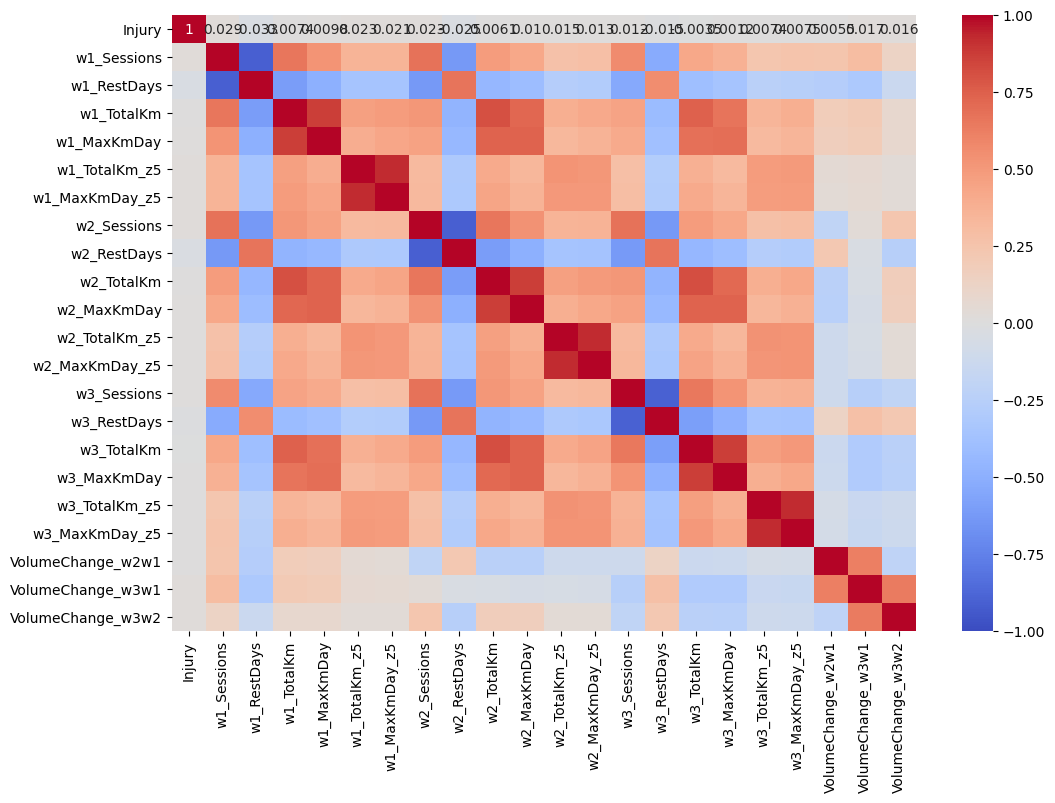

In [59]:
# plot the heatmap 
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_w, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()


### subjective columns - week

There are more features entered by the athletes manually. 

- PreRest
- Exertion
- Success

I leave them behind here, as we won't have a similar column in the Internal Dataset that we want to compair in the end.

as the factbased columns don't show any correlaion, I check the subjectiv features

In [84]:
# MACRO perspective with focus on the manually entered data 

correlation_matrix_wS = df_inj_weeks[['Injury', 
                                'w1_AvgExertion',
                                'w1_MinExertion',
                                'w1_MaxExertion',
                                'w1_AvgTrainingSuccess',
                                'w1_MinTrainingSuccess',
                                'w1_MaxTrainingSuccess',
                                'w1_AvgPreRest',
                                'w1_MinPreRest',
                                'w1_MaxPreRest',

                                'w2_AvgExertion',
                                'w2_MinExertion',
                                'w2_MaxExertion',
                                'w2_AvgTrainingSuccess',
                                'w2_MinTrainingSuccess',
                                'w2_MaxTrainingSuccess',
                                'w2_AvgPreRest',
                                'w2_MinPreRest',
                                'w2_MaxPreRest',

                                'w3_AvgExertion',
                                'w3_MinExertion',
                                'w3_MaxExertion',
                                'w3_AvgTrainingSuccess',
                                'w3_MinTrainingSuccess',
                                'w3_MaxTrainingSuccess',
                                'w3_AvgPreRest',
                                'w3_MinPreRest',
                                'w3_MaxPreRest',
                                ]].corr()

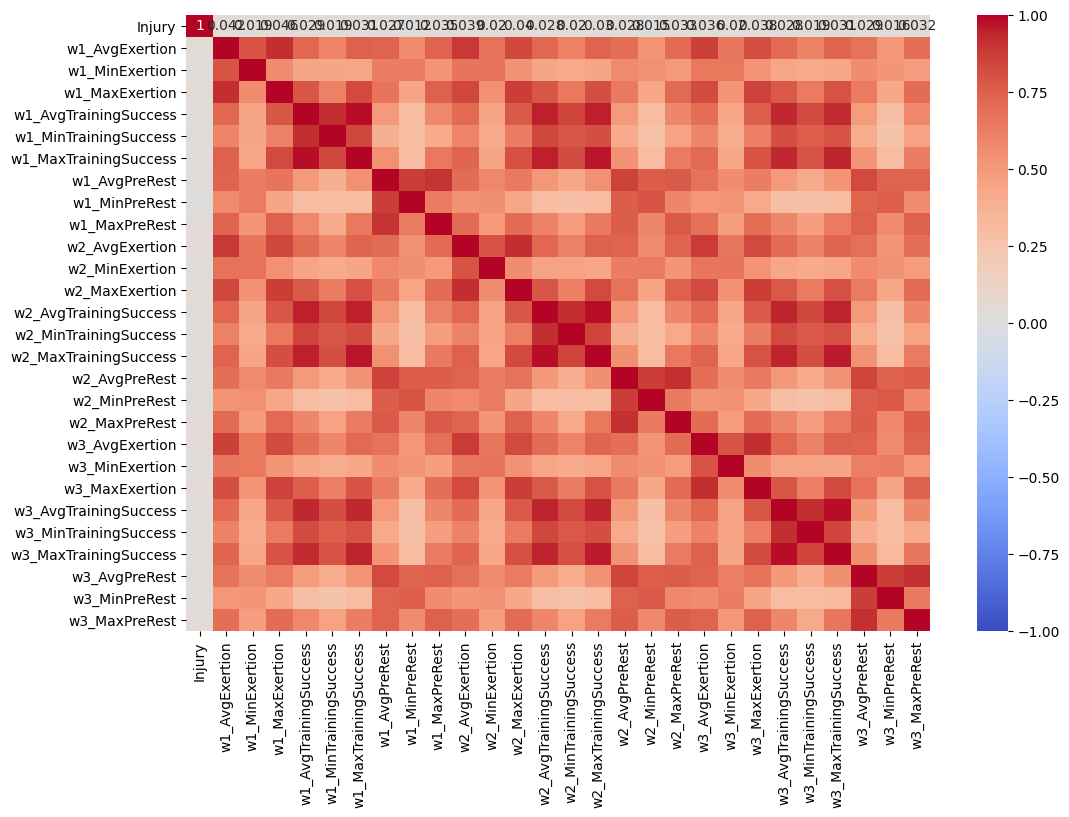

In [85]:
# plot the heatmap 
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_wS, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()


In [86]:
# print the correlation to Injury

column_name = 'Injury'

for col in correlation_matrix_wS.columns:
    if col != column_name:  # Skip 'Injury' itself
        injury_corr = correlation_matrix_wS.at[col, column_name]  # Get correlation value
        abs_corr = abs(injury_corr)

        # Determine correlation strength category
        if abs_corr < 0.1:
            description = "❌ No significant correlation"
        elif abs_corr < 0.3:
            description = "Low correlation"
        elif abs_corr < 0.5:
            description = "Medium correlation"
        elif abs_corr < 0.7:
            description = "High correlation"
        elif abs_corr < 0.9:
            description = "Very high correlation"
        elif abs_corr < 1.0:
            description = "Nearly perfect correlation"
        else:
            description = "Perfect correlation"

        print(f"{col}: {description} ({injury_corr:.5f})")



w1_AvgExertion: ❌ No significant correlation (0.04225)
w1_MinExertion: ❌ No significant correlation (0.01885)
w1_MaxExertion: ❌ No significant correlation (0.04567)
w1_AvgTrainingSuccess: ❌ No significant correlation (0.02877)
w1_MinTrainingSuccess: ❌ No significant correlation (0.01867)
w1_MaxTrainingSuccess: ❌ No significant correlation (0.03122)
w1_AvgPreRest: ❌ No significant correlation (0.02656)
w1_MinPreRest: ❌ No significant correlation (0.01244)
w1_MaxPreRest: ❌ No significant correlation (0.03478)
w2_AvgExertion: ❌ No significant correlation (0.03889)
w2_MinExertion: ❌ No significant correlation (0.02035)
w2_MaxExertion: ❌ No significant correlation (0.03980)
w2_AvgTrainingSuccess: ❌ No significant correlation (0.02796)
w2_MinTrainingSuccess: ❌ No significant correlation (0.02046)
w2_MaxTrainingSuccess: ❌ No significant correlation (0.02982)
w2_AvgPreRest: ❌ No significant correlation (0.02794)
w2_MinPreRest: ❌ No significant correlation (0.01512)
w2_MaxPreRest: ❌ No signific

### combined - days

maybe the perspective of 7 days before shows more correlation

In [87]:
# micro perspective with all columns

correlation_matrix_d = df_inj_days[['Injury', 
                       'd7_Sessions',
                        'd7_RestDay',
                        'd7_TotalKm',
                        'd7_KmZ3z4',
                        'd7_KmZ5',
                        'd7_KmSprint',
                        'd7_StrengthTraining',
                        'd7_HoursAlternativeTraining',
                        'd7_PreRest',
                        'd7_Exertion',
                        'd7_TrainingSuccess',
                        'd6_Sessions',
                        'd6_RestDay',
                        'd6_TotalKm',
                        'd6_KmZ3z4',
                        'd6_KmZ5',
                        'd6_KmSprint',
                        'd6_StrengthTraining',
                        'd6_HoursAlternativeTraining',
                        'd6_PreRest',
                        'd6_Exertion',
                        'd6_TrainingSuccess',
                        'd5_Sessions',
                        'd5_RestDay',
                        'd5_TotalKm',
                        'd5_KmZ3z4',
                        'd5_KmZ5',
                        'd5_KmSprint',
                        'd5_StrengthTraining',
                        'd5_HoursAlternativeTraining',
                        'd5_PreRest',
                        'd5_Exertion',
                        'd5_TrainingSuccess',
                        'd4_Sessions',
                        'd4_RestDay',
                        'd4_TotalKm',
                        'd4_KmZ3z4',
                        'd4_KmZ5',
                        'd4_KmSprint',
                        'd4_StrengthTraining',
                        'd4_HoursAlternativeTraining',
                        'd4_PreRest',
                        'd4_Exertion',
                        'd4_TrainingSuccess',
                        'd3_Sessions',
                        'd3_RestDay',
                        'd3_TotalKm',
                        'd3_KmZ3z4',
                        'd3_KmZ5',
                        'd3_KmSprint',
                        'd3_StrengthTraining',
                        'd3_HoursAlternativeTraining',
                        'd3_PreRest',
                        'd3_Exertion',
                        'd3_TrainingSuccess',
                        'd2_Sessions',
                        'd2_RestDay',
                        'd2_TotalKm',
                        'd2_KmZ3z4',
                        'd2_KmZ5',
                        'd2_KmSprint',
                        'd2_StrengthTraining',
                        'd2_HoursAlternativeTraining',
                        'd2_PreRest',
                        'd2_Exertion',
                        'd2_TrainingSuccess',
                        'd1_Sessions',
                        'd1_RestDay',
                        'd1_TotalKm',
                        'd1_KmZ3z4',
                        'd1_KmZ5',
                        'd1_KmSprint',
                        'd1_StrengthTraining',
                        'd1_HoursAlternativeTraining',
                        'd1_PreRest',
                        'd1_Exertion',
                        'd1_TrainingSuccess',
                        ]].corr()


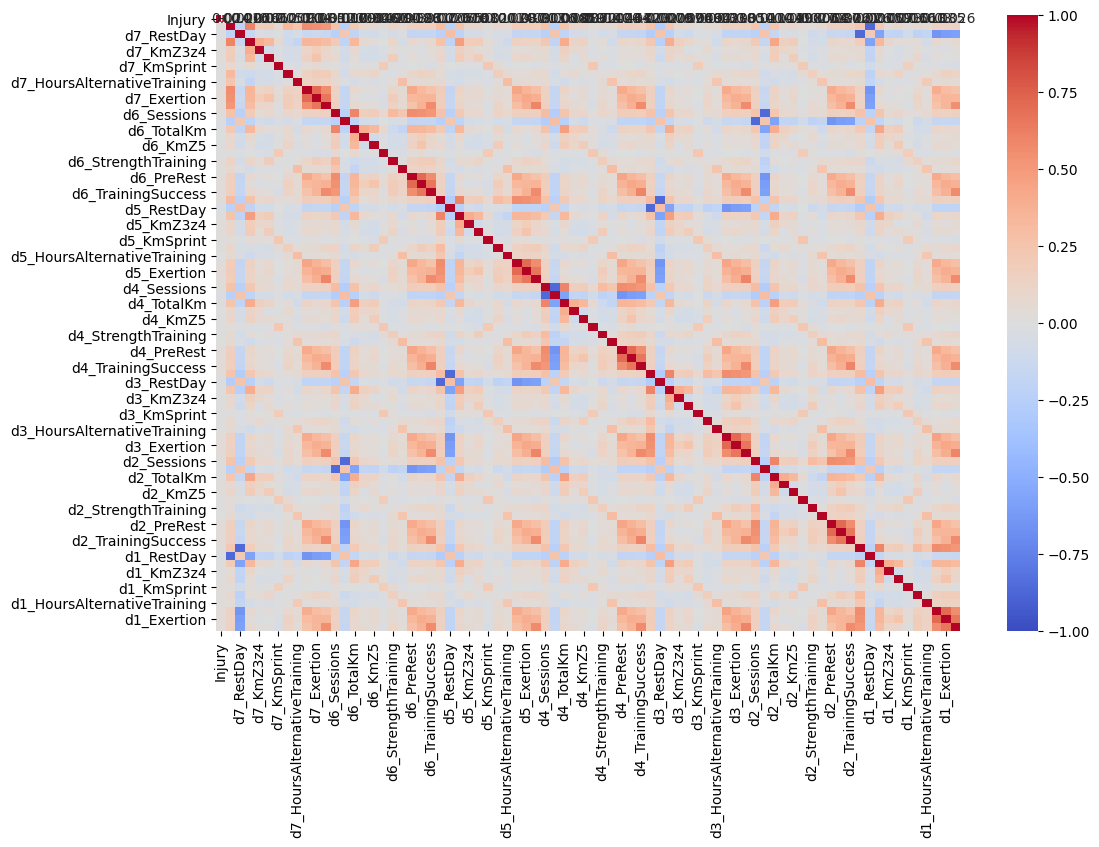

In [88]:
# plot the heatmap 
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix_d, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()


In [89]:
# print the correlation to Injury

column_name = 'Injury'

for col in correlation_matrix_d.columns:
    if col != column_name:  # Skip 'Injury' itself
        injury_corr = correlation_matrix_d.at[col, column_name]  # Get correlation value
        abs_corr = abs(injury_corr)

        # Determine correlation strength category
        if abs_corr < 0.1:
            description = "❌ No significant correlation"
        elif abs_corr < 0.3:
            description = "Low correlation"
        elif abs_corr < 0.5:
            description = "Medium correlation"
        elif abs_corr < 0.7:
            description = "High correlation"
        elif abs_corr < 0.9:
            description = "Very high correlation"
        elif abs_corr < 1.0:
            description = "Nearly perfect correlation"
        else:
            description = "Perfect correlation"

        print(f"{col}: {description} ({injury_corr:.5f})")



d7_Sessions: ❌ No significant correlation (0.02409)
d7_RestDay: ❌ No significant correlation (-0.02206)
d7_TotalKm: ❌ No significant correlation (0.01595)
d7_KmZ3z4: ❌ No significant correlation (0.00066)
d7_KmZ5: ❌ No significant correlation (0.01990)
d7_KmSprint: ❌ No significant correlation (0.01161)
d7_StrengthTraining: ❌ No significant correlation (0.00571)
d7_HoursAlternativeTraining: ❌ No significant correlation (-0.00911)
d7_PreRest: ❌ No significant correlation (0.03128)
d7_Exertion: ❌ No significant correlation (0.03975)
d7_TrainingSuccess: ❌ No significant correlation (0.03488)
d6_Sessions: ❌ No significant correlation (0.01169)
d6_RestDay: ❌ No significant correlation (-0.01748)
d6_TotalKm: ❌ No significant correlation (-0.00905)
d6_KmZ3z4: ❌ No significant correlation (-0.00336)
d6_KmZ5: ❌ No significant correlation (0.00049)
d6_KmSprint: ❌ No significant correlation (0.00611)
d6_StrengthTraining: ❌ No significant correlation (0.02879)
d6_HoursAlternativeTraining: ❌ No sig

## 2.3.3 Hypothesis 3b: rejected

There are no correlation with injury